# Holme-Kim Graph (PA Clustering)

### Libraries

In [1]:
## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
color_map = ["steelblue"]

### Supporting Functions

In [2]:
## supporting functions
from support.preprocessing import sort_adjacency, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single, generate_manifold, generate_topol_manifold, generate_topol_manifold
from support.param_generating import generate_param_graph_manifold, generate_param_topol_manifold
from support.latent_space import vis2D, visDistr

## import model
from models.VAE import VAE

Using TensorFlow backend.


## Loading and Preprocessing Network Data

### Loading Network Data

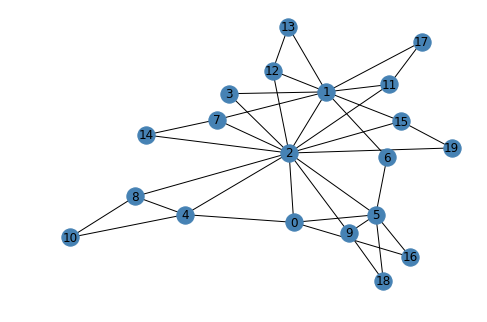

In [32]:
def get_graph(n,e,p,draw): 

    # n nodes
    # e number of edges to attach from new node to existing node
    # p probability of adding a triangle after adding a random edge

    g = random_graphs.powerlaw_cluster_graph(n, e, p, seed=None)

    if draw:
        nx.draw_spring(g, node_color = color_map, with_labels = True)
        plt.show()
    
    return g

g = get_graph(n = 20, e = 2, p = 0.8, draw = True)

# Generating Training Data

In [189]:
def generate_data(dataArgs): 
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], diag_offset = dataArgs["diag_offset"])))

    ## Ground Truth Labels ______________________________

    T = list()
    T_array = np.zeros((dataArgs["n_graphs"],3))

    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):

        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

        #e = random.randint(2, n)
        e = random.randint(1, 4)
        p = random.uniform(0, 0.4)  # float in range 0 - 1 
        g = get_graph(n, e, p, draw = False)
        
        #nx.draw(g)
        #plt.show()

        g, a = sort_adjacency(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])


        ## Build Data Arrays___________________________________________________

        G[i] = a_transformed

        t = dict()
        t["n"] = n
        t["e"] = e
        t["p"] = p
        
        T_array[i] = [n,e,p]
        T.append(t)



    ## Input and Output Size ___________________________________________________________

    T, input_shape, output_shape = prepare_in_out(T, dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]))
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale parameters in T_array for smoother training
    scaler = MinMaxScaler()
    scaler.fit(T_array)
    T_array = scaler.transform(T_array)
    
    return G,T,T_array,input_shape,output_shape,scaler
    
dataArgs = {"n_graphs": 20000, "n_max": 24, "fix_n": True, "diag_offset": 0, "diag_value": 1, "clip": True}  #"diag_offset" - 1 == full adjacency
G, T, T_array, input_shape, output_shape,scaler = generate_data(dataArgs)

input_shape: (300,) , output_shape: 300


## Build and Train Model

In [207]:
## libs
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split


class VAE():

    # reparameterization trick
    # instead of sampling from Q(z|X), sample eps = N(0,I)
    # then z = z_mean + sqrt(var)*eps

    def sampling(self, args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def __init__(self, modelArgs, trainArgs, G, T_array):

        ## MODEL ______________________________________________________________

        ## Multi-layer Perceptron without convolutions__________________________________
        if modelArgs["nn_architecture"] == "mlp":
            ## 1) build encoder model __________________________

            inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
            x = Dense(128, activation='relu')(inputs)
            x = Dense(64, activation='relu')(x)
            x = Dense(12, activation='relu')(x)
            z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
            z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

            # use reparameterization trick to push the sampling out as input
            # note that "output_shape" isn't necessary with the TensorFlow backend
            z = Lambda(self.sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])

            ## 2) build decoder model __________________________

            latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
            y = Dense(12, activation='relu')(latent_inputs)
            y = Dense(64, activation='relu')(y)
            y = Dense(128, activation='relu')(y)
            graph_outputs = Dense(modelArgs["output_shape"], activation='sigmoid')(y)

        ## Convolutional Neural Network_________________________________

        if modelArgs["nn_architecture"] == "2D_conv":

            ## 1) build encoder model____________________________________

            inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
            x = inputs

            for i in range(2):
                modelArgs['filters'] *= 2
                x = Conv2D(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu',
                           strides=2, padding='same')(x)

            # shape info needed to build decoder model
            shape = K.int_shape(x)

            # generate latent vector Q(z|X)
            x = Flatten()(x)
            x = Dense(16, activation='relu')(x)
            z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
            z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

            # use reparameterization trick to push the sampling out as input
            # note that "output_shape" isn't necessary with the TensorFlow backend
            z = Lambda(self.sampling, output_shape=(modelArgs["output_shape"],), name='z')([z_mean, z_log_var])

            ## 2) build decoder model____________________________________

            latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
            x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
            x = Reshape((shape[1], shape[2], shape[3]))(x)

            for i in range(2):
                x = Conv2DTranspose(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'],
                                    activation='relu', strides=2, padding='same')(x)
                modelArgs['filters'] //= 2

            graph_outputs = Conv2DTranspose(filters=1, kernel_size=modelArgs['kernel_size'], activation='sigmoid',
                                            padding='same', name='decoder_output')(x)

        ## 2.2) decode growth parameters_________________________________

        # g = Dense(4, activation='relu')(latent_inputs)
        p = Dense(2, activation='relu')(latent_inputs)
        param_outputs = Dense(modelArgs["growth_param"], activation='linear')(p)

        ## INSTANTIATE___________________________________

        if modelArgs["param_loss"] == False:
            ## 1) instantiate encoder model
            encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
            encoder.summary()
            # plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

            ## 2) instantiate decoder model
            graph_decoder = Model(latent_inputs, graph_outputs, name='decoder')
            graph_decoder.summary()
            # plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

            ## 3) instantiate VAE model
            outputs = graph_decoder(encoder(inputs)[2])
            vae = Model(inputs, outputs, name='conv_vae')
            # vae.summary()

        if modelArgs["param_loss"]:
            ## 1) instantiate encoder model
            encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
            encoder.summary()
            # plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

            ## 2) instantiate decoder model
            graph_decoder = Model(latent_inputs, graph_outputs, name='graph_decoder')
            graph_decoder.summary()
            # plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

            ## 2.2) decode growth parameters
            param_decoder = Model(latent_inputs, param_outputs, name='param_decoder')
            param_decoder.summary()

            ## 3) instantiate VAE model
            graph_outputs = graph_decoder(encoder(inputs)[2])
            param_outputs = param_decoder(encoder(inputs)[2])
            outputs = [graph_outputs, param_outputs]

            vae = Model(inputs, outputs, name='vae_graph')
            # vae.summary()

        ## TRAINING ______________________________________

        ## Train and Validation Split _______________________________________________

        x_train, x_test, y_train, y_test = train_test_split(G, T_array, test_size=trainArgs["data_split"],
                                                            random_state=1, shuffle=True)

        def reconstr_loss_func(y_true, y_pred):

            ## RECONSTRUCTION LOSS_______________________

            if trainArgs["loss"] == "mse":

                if modelArgs["nn_architecture"] == "mlp":
                    reconstruction_loss = mse(y_true[0], y_pred[0])
                    reconstruction_loss *= modelArgs["input_shape"]

                if modelArgs["nn_architecture"] == "2D_conv":
                    reconstruction_loss = mse(K.flatten(y_true[0]), K.flatten(y_pred[0]))
                    reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]

            if trainArgs["loss"] == "binary_crossentropy":

                if modelArgs["nn_architecture"] == "mlp":
                    reconstruction_loss = binary_crossentropy(y_true[0], y_pred[0])
                    reconstruction_loss *= modelArgs["input_shape"]

                if modelArgs["nn_architecture"] == "2D_conv":
                    reconstruction_loss = binary_crossentropy(K.flatten(y_true[0]), K.flatten(y_pred[0]))
                    reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]

            ## KL LOSS _____________________________________________

            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            ## COMPLETE LOSS __________________________________________________

            reconstr_loss = K.mean(reconstruction_loss + (trainArgs["beta"] * kl_loss))

            return reconstr_loss

        # vae.add_loss(vae_loss)
        # vae_loss = reconstr_loss_func(inputs, outputs[0])

        ## PARAMETER LOSS_______________________

        def param_loss_func(y_true, y_pred):

            param_loss = mse(y_pred[1], y_true[1])

            return param_loss

        if modelArgs["param_loss"] == False:
            vae.compile(optimizer='adam', loss=reconstr_loss_func, metrics=['accuracy'])
            vae.summary()

        if modelArgs["param_loss"]:
            vae.compile(optimizer='adam', loss=[reconstr_loss_func, param_loss_func], loss_weights = [0, 200], metrics=['accuracy'])
            vae.summary()

        ## TRAIN______________________________________________

        # load the autoencoder weights

        if trainArgs["weights"] == "load":

            vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

        # train the autoencoder

        elif trainArgs["weights"] == "train":

            # Set callback functions to early stop training and save the best model so far
            callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(
                filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5",
                save_best_only=True)]

            if modelArgs["param_loss"] == False:
                vae.fit(x_train, [x_train], epochs=trainArgs["epochs"], batch_size=trainArgs["batch_size"],
                        callbacks=callbacks, validation_data=(x_test, [x_test]))
                vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")
                models = (encoder, graph_decoder)

            if modelArgs["param_loss"]:
                vae.fit(x_train, [x_train, y_train], epochs=trainArgs["epochs"], batch_size=trainArgs["batch_size"],
                        callbacks=callbacks, validation_data=(x_test, [x_test, y_test]))
                vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")
                models = (encoder, graph_decoder, param_decoder)

        data = (x_test, y_test)

        self.model = models
        self.data = data

In [213]:
# network parameters
modelArgs = {"nn_architecture": "mlp", "param_loss": True, "latent_dim": 2, "growth_param": T_array.shape[1], "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape}
trainArgs = {"beta": 1, "loss": "binary_crossentropy", "weights": "train", "early_stop": 1, "batch_size": 32, "epochs": 50, "data_split": 0.1}

vae = VAE(modelArgs, trainArgs, G, T_array)

models = vae.model 
data = vae.data

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 300)          0                                            
__________________________________________________________________________________________________
dense_246 (Dense)               (None, 128)          38528       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_247 (Dense)               (None, 64)           8256        dense_246[0][0]                  
__________________________________________________________________________________________________
dense_248 (Dense)               (None, 12)           780         dense_247[0][0]                  
__________________________________________________________________________________________________
z_mean (De

# Latent Space Analysis

# Encoder

# Iterate through single data dimension and oberseve single latent space dimension  

Mutual Information Gap: 0.7733016442523112


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:357: RuntimeWarning: divide by zero encountered in double_scalars


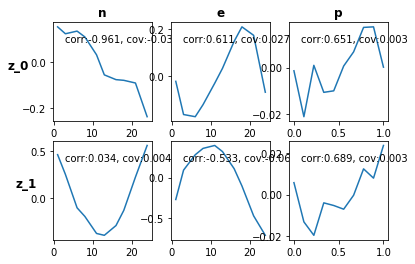

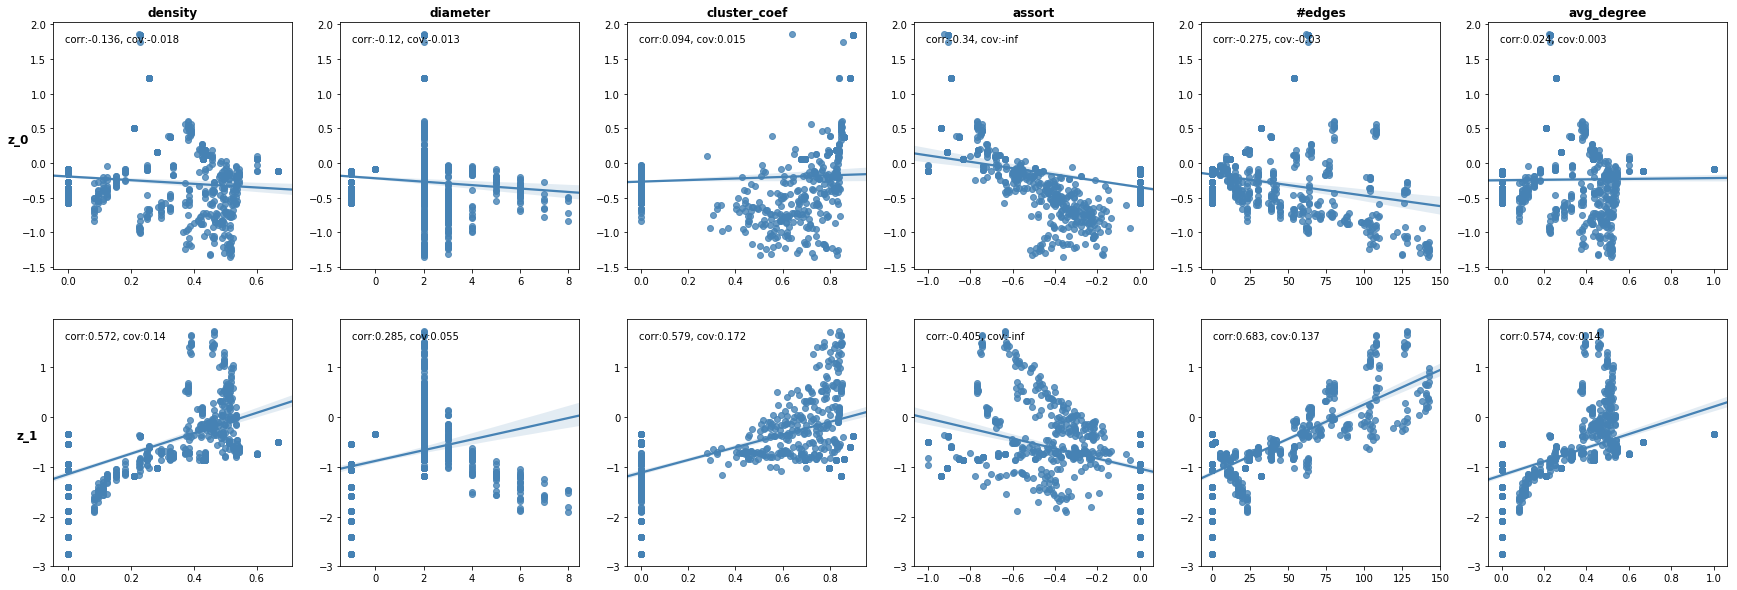

In [8]:
def latent_space_feature_correlation(analyzeArgs, modelArgs, models,batch_size=128,model_name="vae_graph"):

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models
        

    if analyzeArgs["root_params"] == 2:
        
        ## Generate Graph Data_______________________________
    
        #N = np.linspace(1,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype=int)  # array 1,2,3,4,5 - n_max / n_config_graphs
        n = dataArgs["n_max"]
        E = np.linspace(1,n,analyzeArgs["n_config_graphs"], dtype=int)  
        P = np.linspace(0,1,analyzeArgs["n_config_graphs"])  # array 0.1, 0.2 - 1 / n_config_graphs 

        ## growth and topol parameters
        growth_params = ["e", "p"]
        topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(growth_params)))
        Topol = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(topol_params)))

        ## iterate through topological features
        graph_configs = np.asarray(list(itertools.product(E,P)))
        

        for i, (e,p) in enumerate(graph_configs):

            ## Generate Graph Type ______________________________________________
            
            g = get_graph(int(n), int(e), p, draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth[i,0] = int(e)
            Growth[i,1] = p

            Topol[i,0] = density
            Topol[i,1] = diameter
            Topol[i,2] = cluster_coef
            Topol[i,3] = assort
            Topol[i,4] = edges
            Topol[i,5] = avg_degree
  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
                
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            #mi = compute_mi(P, np.squeeze(z_mean))
            mig = compute_mig(Growth, z_mean)
        
        
        ##  Reshape Array according to Parameters  
        z_mean_growth = np.reshape(z_mean, (analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
        Growth = np.reshape(Growth,(analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
            
        ## 1.) Growth Parameters________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        fig, ax = plt.subplots(nrows= z_mean_growth.shape[-1] , ncols= len(growth_params))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):
                
                if feature == 0:
                    feature_1 = 1
                if feature == 1:
                    feature_1 = 0

                y = np.mean(z_mean_growth[:,:,latent_z], axis= feature_1)
                x = np.mean(Growth[:,:,feature], axis= feature_1)
                col.plot(x, y)  
                col.set_ylim([np.mean(y) - 3.0, np.mean(y) + 3.0])

                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')


        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean_growth.shape[-1])]
        cols = [t for t in growth_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



        ## 2.) Graph Topologies________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        ##  Reshape Array according to Parameters  
        #Topol = np.reshape(Topol,(n_config_graphs, n_config_graphs, -1))

        fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= len(topol_params), figsize=(30,10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                ## toDO: change sorting
                y = z_mean[:,latent_z]
                x = Topol[:,feature]
                sns.regplot(x, y, color="steelblue", ax=col)
                col.set_ylim([np.mean(y) - 3.0, np.mean(y) + 3.0])
                #col.scatter(x, y) 

                # set axes range
                #plt.xlim(-4, 4)
                #plt.ylim(-4, 4)

               # try:
               #     ## plot trend line
               #     x = np.nan_to_num(x)
               #     y = np.nan_to_num(y)

               #     z = np.polyfit(x, y, 1)
               #     p = np.poly1d(z)
               #     col.plot(x,p(x),"steelblue")
               # except:
               #     pass


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')


            
            
            
    if analyzeArgs["root_params"] == 3:
        
        ## Generate Graph Data_______________________________
    
        N = np.linspace(1,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype=int)  # array 1,2,3,4,5 - n_max / n_config_graphs
        E = np.linspace(1,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype=int)  
        P = np.linspace(0,1,analyzeArgs["n_config_graphs"])  # array 0.1, 0.2 - 1 / n_config_graphs 

        ## growth and topol parameters
        growth_params = ["n", "e", "p"]
        topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(growth_params)))
        Topol = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(topol_params)))

        ## iterate through topological features
        graph_configs = np.asarray(list(itertools.product(N,E,P)))
        

        for i, (n,e,p) in enumerate(graph_configs):

            ## Generate Graph Type ______________________________________________
            try:
                g = get_graph(int(n), int(e), p, draw = False)
            except:
                g = get_graph(int(n), int(n), p, draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth[i,0] = int(n)
            Growth[i,1] = int(e)
            Growth[i,2] = p

            Topol[i,0] = density
            Topol[i,1] = diameter
            Topol[i,2] = cluster_coef
            Topol[i,3] = assort
            Topol[i,4] = edges
            Topol[i,5] = avg_degree
  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
                
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            #mi = compute_mi(P, np.squeeze(z_mean))
            mig = compute_mig(Growth, z_mean)
        
        
        ##  Reshape Array according to Parameters  
        z_mean_growth = np.reshape(z_mean, (analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
        Growth = np.reshape(Growth,(analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
            
        ## 1.) Growth Parameters________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        fig, ax = plt.subplots(nrows= z_mean_growth.shape[-1] , ncols= len(growth_params))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):
                
                if feature == 0:
                    feature_1, feature_2 = 1, 2
                if feature == 1:
                    feature_1, feature_2 = 0, 2
                if feature == 2:
                    feature_1, feature_2 = 0, 1
                
                y = np.mean(z_mean_growth[:,:,:,latent_z], axis= (feature_1, feature_2)) - np.mean(z_mean_growth[:,:,:,latent_z])
                x = np.mean(Growth[:,:,:,feature], axis= (feature_1, feature_2))
                col.plot(x, y)  

                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')


        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean_growth.shape[-1])]
        cols = [t for t in growth_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



        ## 2.) Graph Topologies________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        ##  Reshape Array according to Parameters  
        #Topol = np.reshape(Topol,(n_config_graphs, n_config_graphs, -1))

        fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= len(topol_params), figsize=(30,10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                ## toDO: change sorting
                y = z_mean[:,latent_z]
                x = Topol[:,feature]
                sns.regplot(x, y, color="steelblue", ax=col)
                #col.scatter(x, y) 

                # set axes range
                #plt.xlim(-4, 4)
                #plt.ylim(-4, 4)

               # try:
               #     ## plot trend line
               #     x = np.nan_to_num(x)
               #     y = np.nan_to_num(y)

               #     z = np.polyfit(x, y, 1)
               #     p = np.poly1d(z)
               #     col.plot(x,p(x),"steelblue")
               # except:
               #     pass


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')




## PLOT RESULTS ________________________________________

                        # 2,3
analyzeArgs = {"root_params": 3, "n_config_graphs": 10, "metric": "mig"}
latent_space_feature_correlation(analyzeArgs, modelArgs, models, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize the Latent Space in 2D

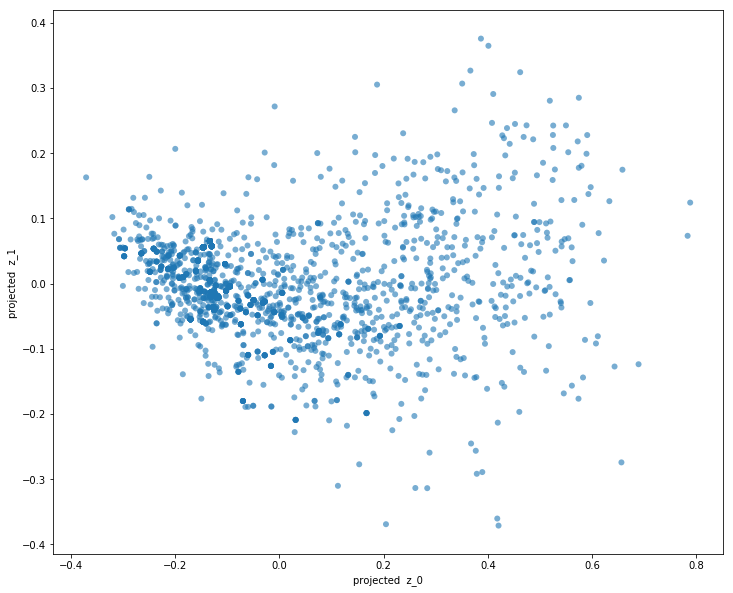

In [14]:
analyzeArgs = {"save_plots": False}
vis2D(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

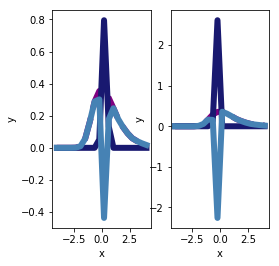

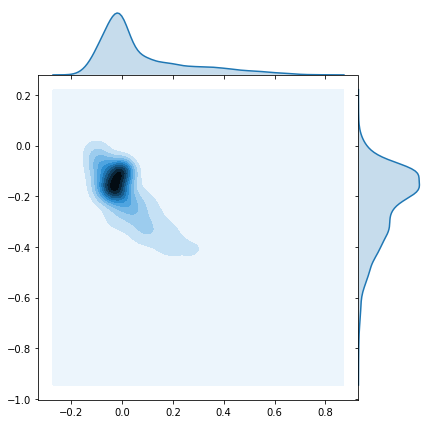

In [15]:
analyzeArgs = {"z": [0,1]}
visDistr(modelArgs, analyzeArgs, models,data,trainArgs["batch_size"])

# Decoder

## Generate a Single Graph Instance

latent dimensions: 2


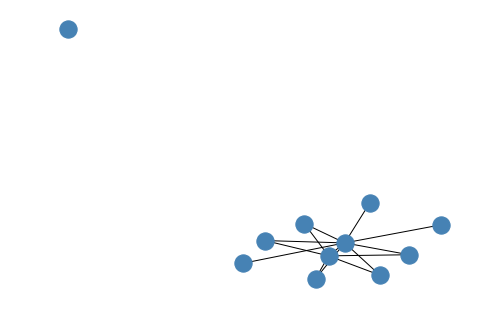

In [16]:
analyzeArgs = {"activations": [0, 0.2], "z": [0,1]}
generate_single(analyzeArgs, modelArgs, dataArgs, models, color_map)

## Generate Interpolated Manifold from Latent Space

In [187]:
from support.preprocessing import reconstruct_adjacency, unpad_matrix

import networkx as nx
import numpy as np

from matplotlib import pylab as plt
import os



## apply decoder and generate data

def generate_single(analyzeArgs, modelArgs, dataArgs, models, color_map):

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models

    print("latent dimensions:", modelArgs["latent_dim"])

    z_sample = np.zeros(modelArgs["latent_dim"])
    z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

    for i, dim in enumerate(analyzeArgs["z"]):
        z_sample[0][dim] = analyzeArgs["activations"][i]

    x_decoded = graph_decoder.predict(z_sample)

    ## reconstruct upper triangular adjacency matrix
    reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])
    reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])

    ## reconstruct graph
    g = nx.from_numpy_matrix(reconstructed_a)
    # reconstructed_a = nx.adjacency_matrix(g).todense()

    nx.draw(g, node_color=color_map)








## DECODER - Latent Space Interpolation____________________________

def generate_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=128):
    print("latent dimensions:", modelArgs["latent_dim"])

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models

    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)



    ## Latent Space Dimension is 2 ______________________

    if modelArgs["latent_dim"] == 2:
        
        ## 1) create adjacency plots_______________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1], analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))


        ## 2) create graph plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(8, 8), dpi = 300)
        # fig.subplots_adjust(hspace = .5, wspace=.001)

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                xi_value = xi ** analyzeArgs["act_scale"]
                yi_value = yi ** analyzeArgs["act_scale"]

                z_sample = np.array([[xi_value, yi_value]])
                x_decoded = graph_decoder.predict(z_sample)

                ## reconstruct upper triangular adjacency matrix
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

                ## 1) create adjacency plots_____________________________________

                figure[i * n: (i + 1) * n,
                j * n: (j + 1) * n] = reconstructed_a

                ## 2) create graph plot_____________________________

                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])
                nx.draw_kamada_kawai(g, node_size=10, node_color=color_map)
                axs[i, j].set_axis_off()

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)

        # Plot_____________________________

        plt.figure(figsize=(10, 10), dpi = 300)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z_0", fontweight='bold')
        plt.ylabel("z_1", fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)














latent dimensions: 2
HI


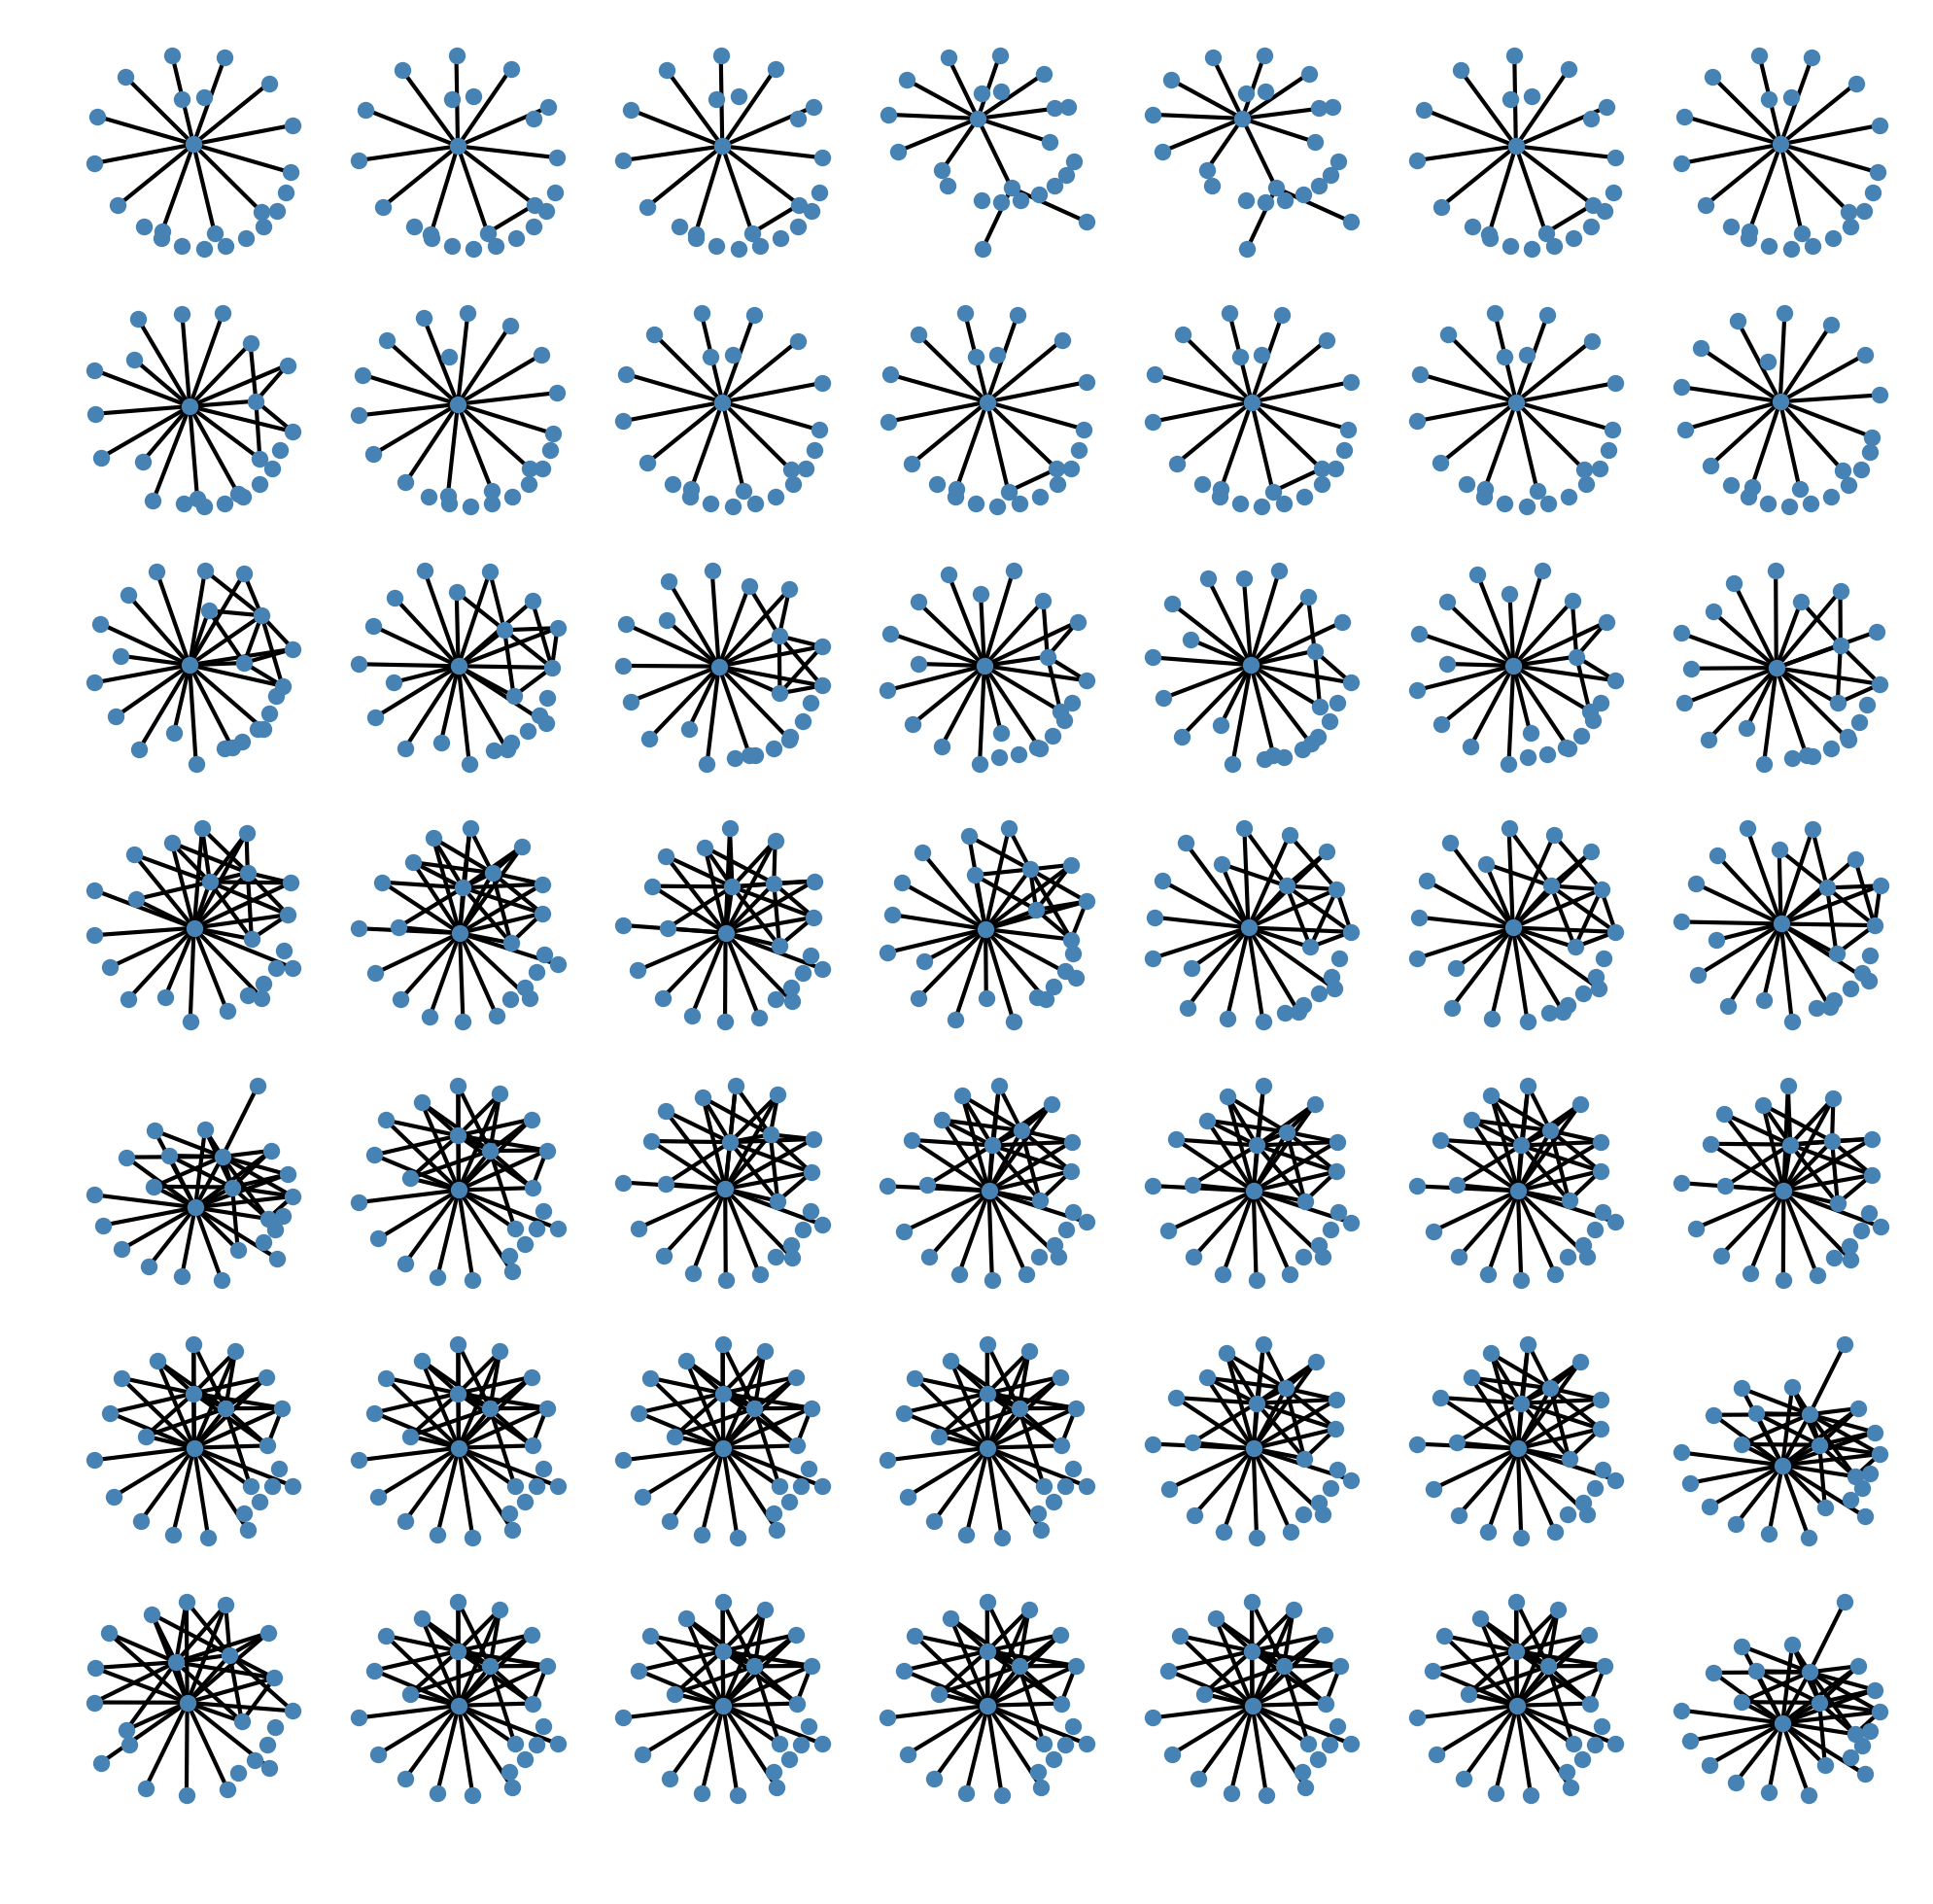

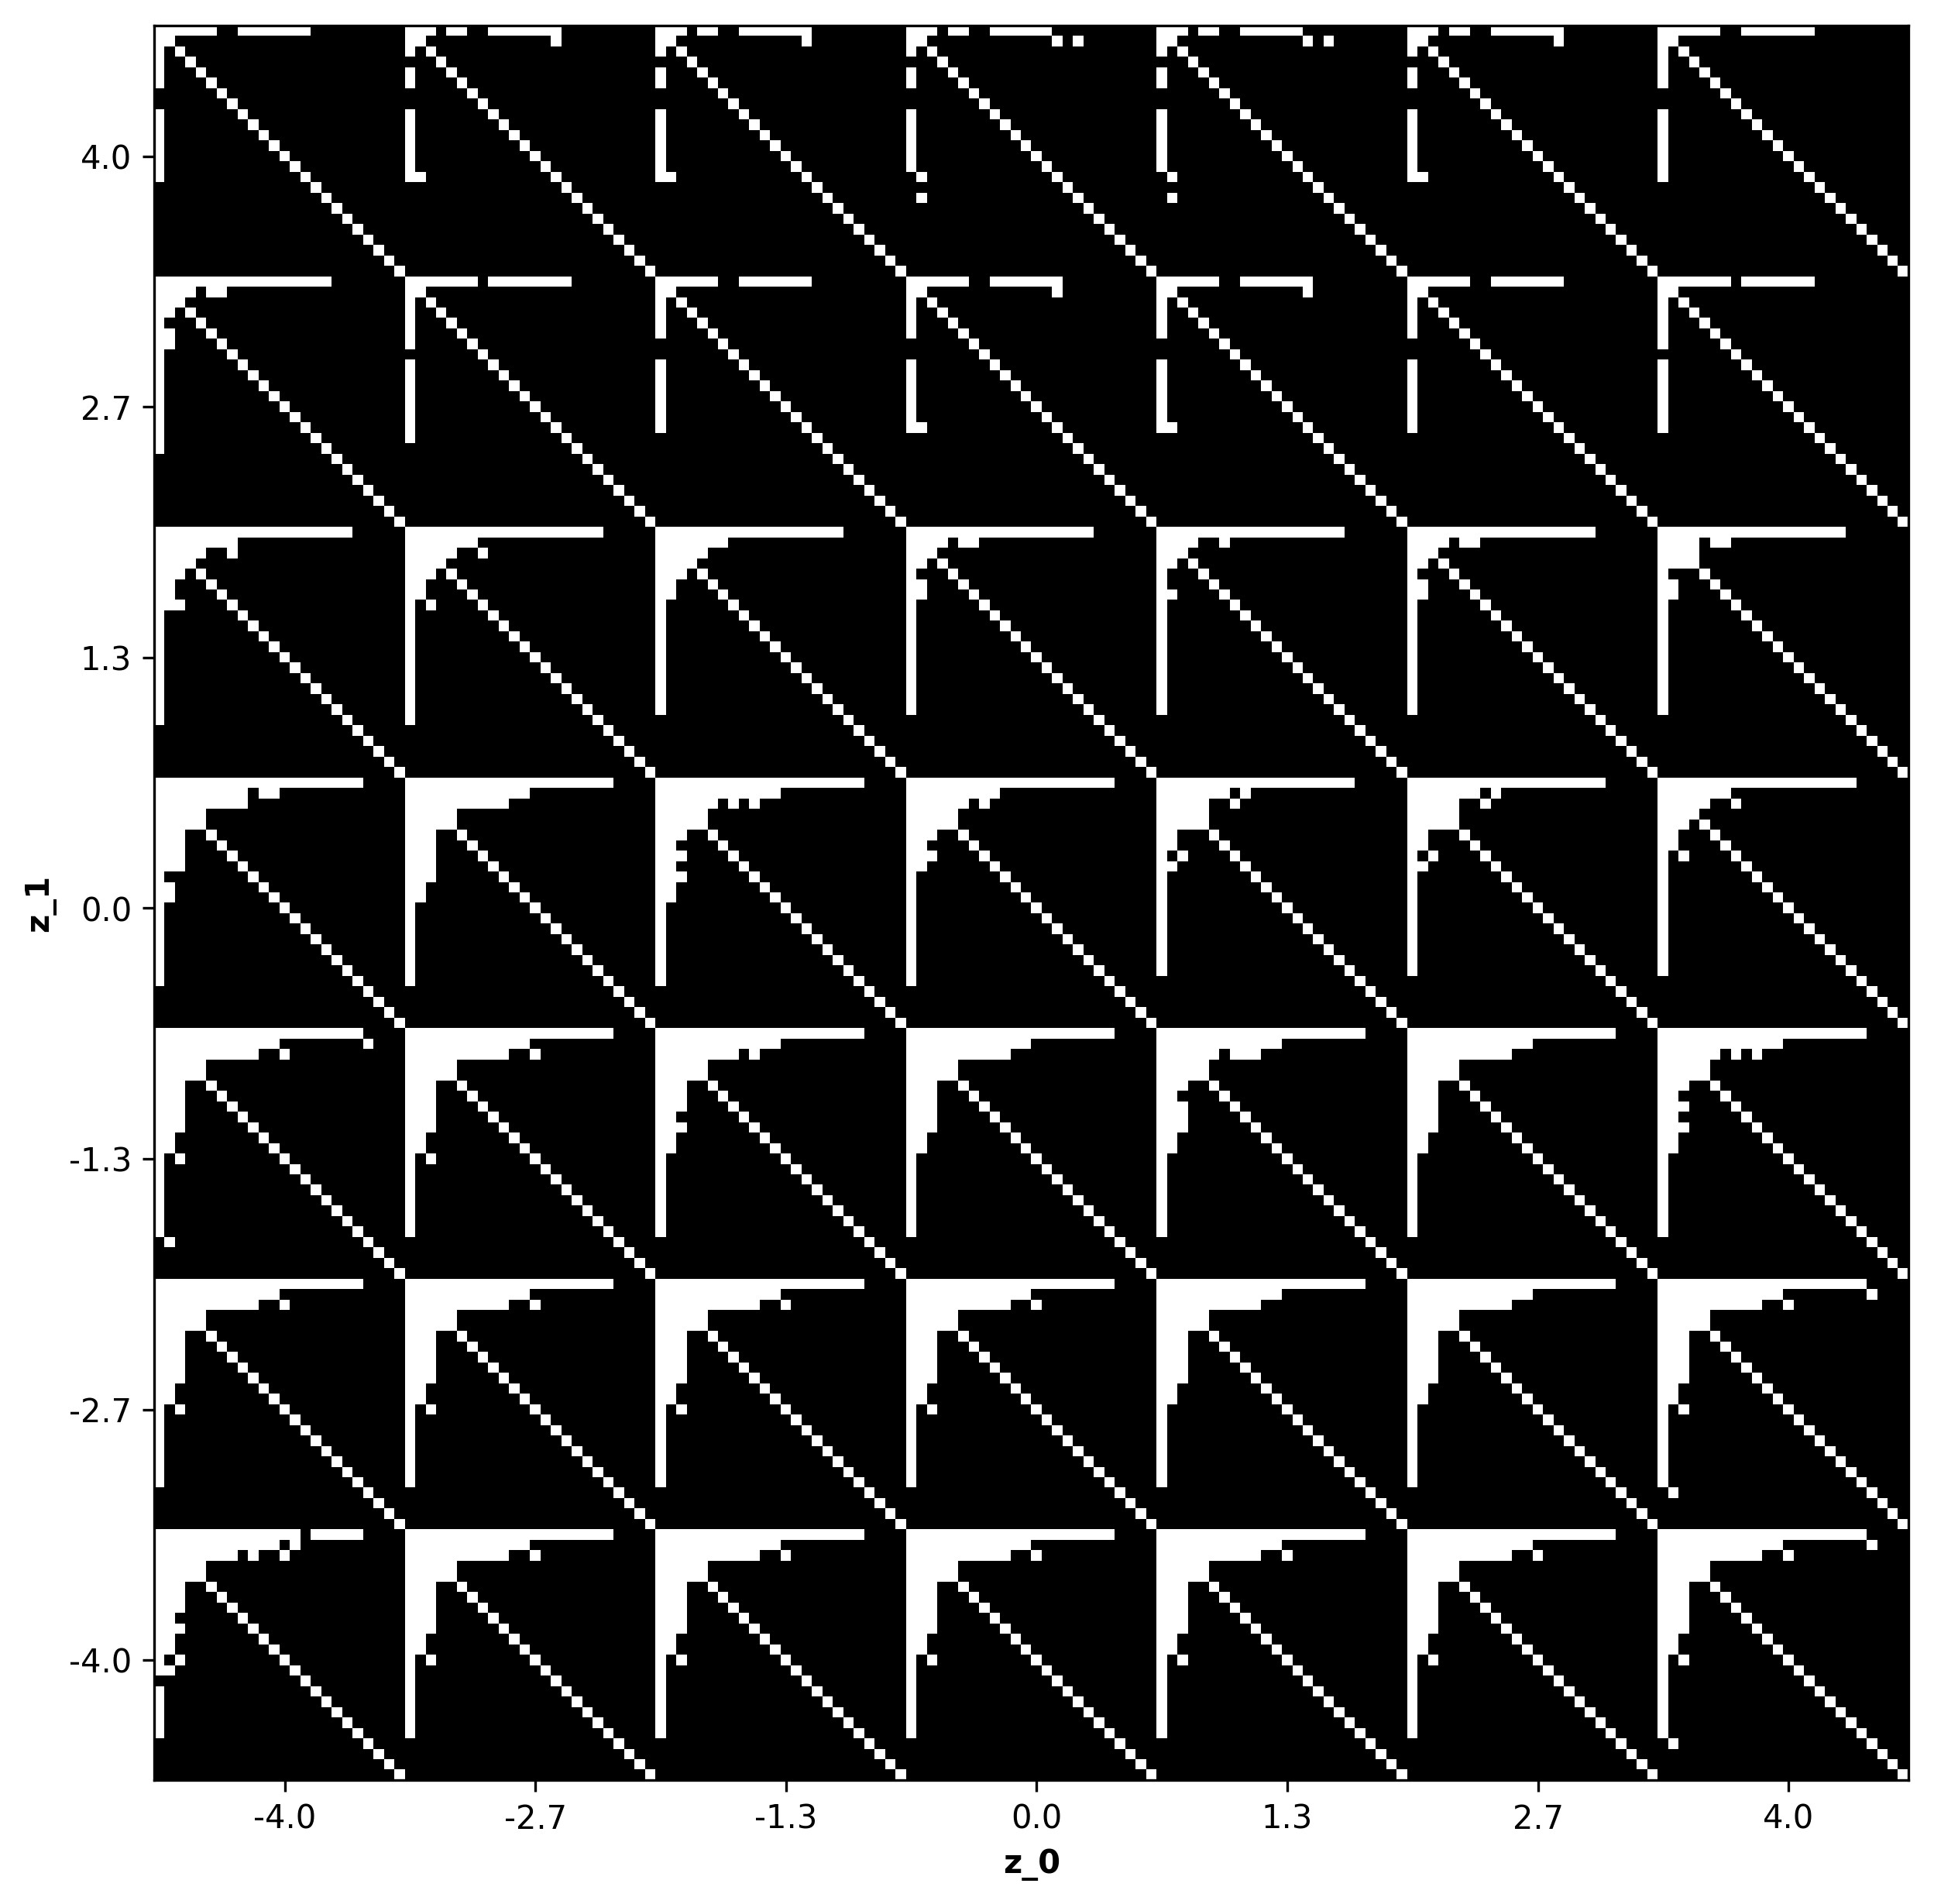

In [202]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 7, "save_plots": False}
generate_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

latent dimensions: 2


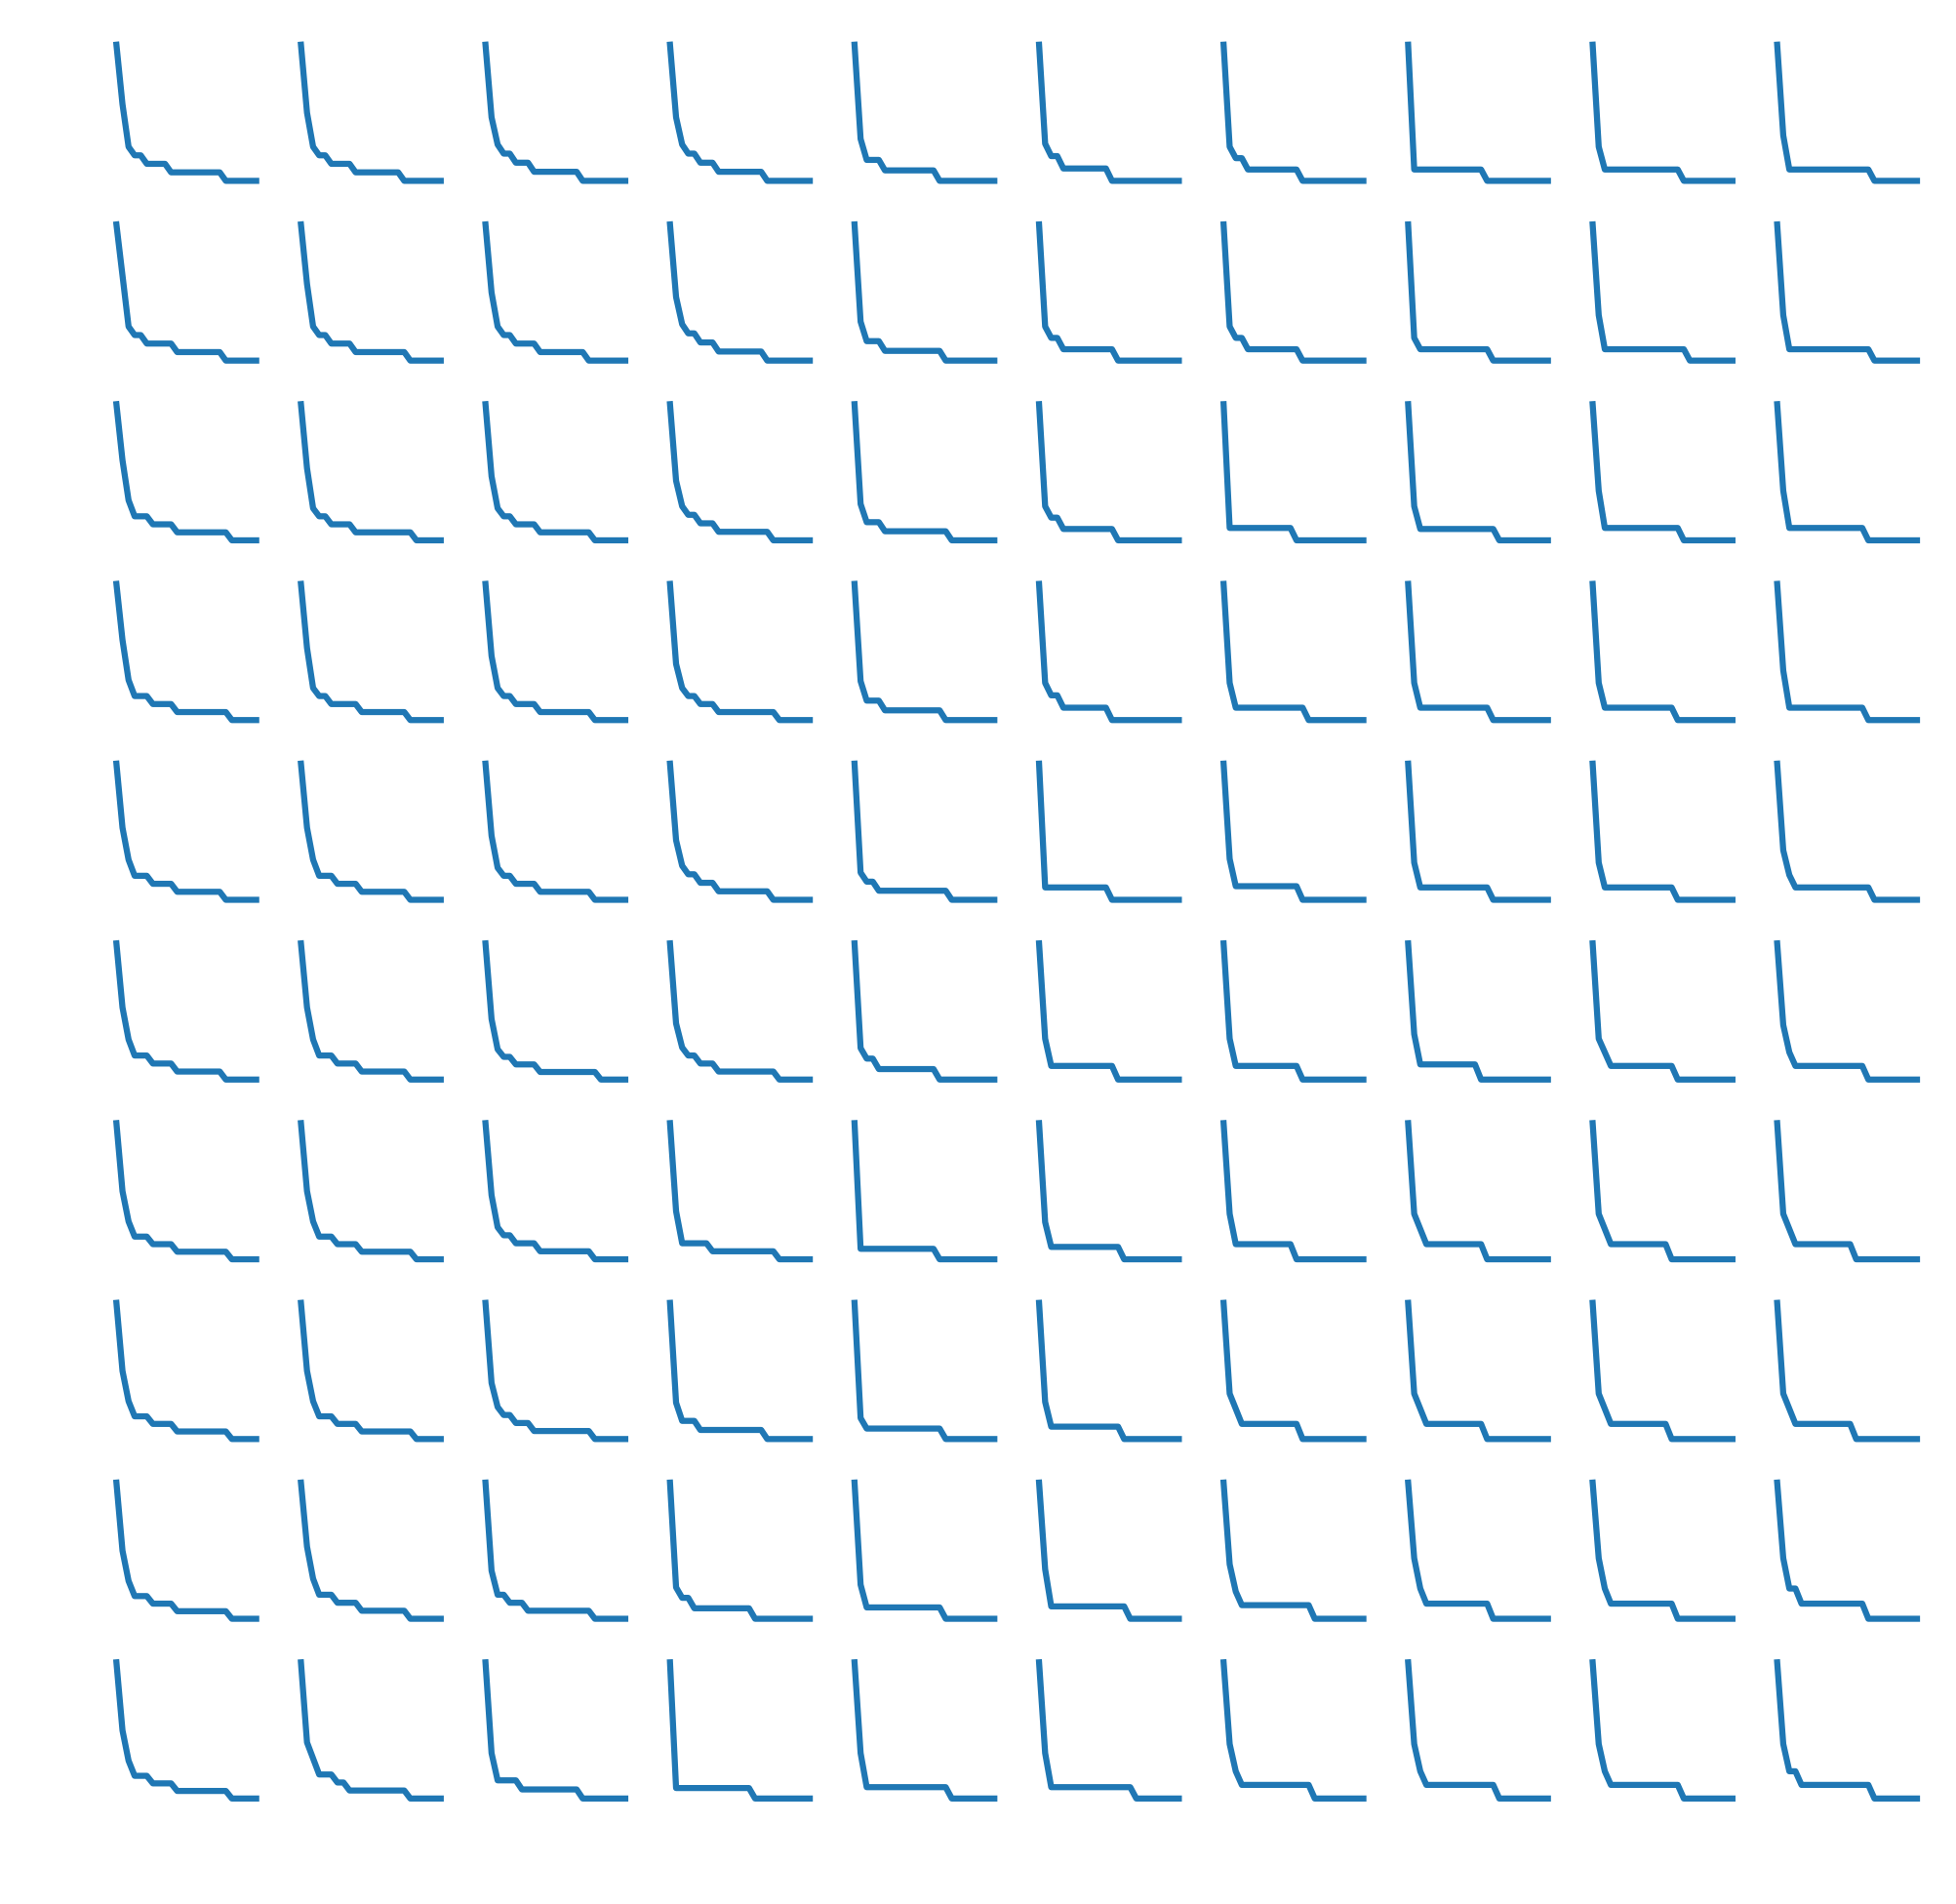

In [105]:
analyzeArgs = {"z": [0,1], "plot": "distr", "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

## "density", "cluster_coef", "assort", "avg_degree"

## Analyze Parameter Encoding

In [ ]:
from support.preprocessing import reconstruct_adjacency, unpad_matrix, sort_adjacency, pad_matrix

import sys
import networkx as nx
from networkx.generators import random_graphs
from networkx.generators import classic
import numpy as np

from matplotlib import pylab as plt
import os


def decode_param(analyzeArgs, dataArgs, scaler, x_decoded):
    ## generate graph from generative parameters
    x_decoded = scaler.inverse_transform(x_decoded)
    x_decoded = np.squeeze(x_decoded)

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "Complete":
        n_gen = np.clip(int(x_decoded), 1, dataArgs["n_max"] - 1)
        g = classic.complete_graph(n_gen)

        params = ("n")
        y_pos = np.arange(len(params))
        param_values = [n_gen / dataArgs["n_max"]]

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "Tree":
        b_gen = np.clip(int(x_decoded[0]), 1, dataArgs["n_max"] - 1)
        h_gen = np.clip(int(x_decoded[1]), 1, dataArgs["n_max"] - 1)
        g = classic.balanced_tree(b_gen, h_gen)

        params = ("b", "h")
        y_pos = np.arange(len(params))
        param_values = [b_gen, h_gen]

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "ER":
        n_gen = np.clip(int(x_decoded[0]), 1, dataArgs["n_max"] - 1)
        p_gen = np.clip(x_decoded[1], 0, 1)
        g = random_graphs.erdos_renyi_graph(n_gen, p_gen, seed=None, directed=False)

        params = ("n", "p")
        y_pos = np.arange(len(params))
        param_values = [n_gen / dataArgs["n_max"], p_gen]

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "PA":
        n_gen = np.clip(int(x_decoded[0]), 2, dataArgs["n_max"] - 1)
        e_gen = np.clip(int(x_decoded[1]), 1, n_gen - 1)
        g = random_graphs.barabasi_albert_graph(n_gen, e_gen, seed=None)

        params = ("n", "e")
        y_pos = np.arange(len(params))
        param_values = [n_gen / dataArgs["n_max"], e_gen / n_gen]

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "HK":
        n_gen = np.clip(int(x_decoded[0]), 1, dataArgs["n_max"] - 1)
        e_gen = np.clip(int(x_decoded[1]), 1, n_gen)
        p_gen = np.clip(x_decoded[2], 0, 1)
        g = random_graphs.powerlaw_cluster_graph(n_gen, e_gen, p_gen, seed=None)

        params = ("n", "e", "p")
        y_pos = np.arange(len(params))
        param_values = [n_gen / dataArgs["n_max"], e_gen / n_gen, p_gen]

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "SW":
        n_gen = np.clip(int(x_decoded[0]), 1, dataArgs["n_max"] - 1)
        k_gen = np.clip(int(x_decoded[1]), 0, n_gen - 1)
        p_gen = np.clip(x_decoded[2], 0, 1)
        g = random_graphs.newman_watts_strogatz_graph(n_gen, k_gen, p_gen, seed=None)  # no edges are removed

        params = ("n", "k", "p")
        y_pos = np.arange(len(params))
        param_values = [n_gen / dataArgs["n_max"], k_gen / n_gen, p_gen]

        return g, y_pos, params, param_values

    

def generate_param_graph_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size, scaler):
    # DECODER - Latent Space Interpolation____________________________

    print("latent dimensions:", modelArgs["latent_dim"])

    if modelArgs["param_loss"] == False:
        sys.exit("modelArgs[param_loss] should be True")
    else:
        encoder, graph_decoder, param_decoder = models  # trained models

    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)

    
    ## Latent Space Dimension is 2 ______________________
    print("hi")

    if modelArgs["latent_dim"] == 2:

        ## 1) create adjacency plots_______________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))

        ## 2) create graph plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(8, 8), dpi=300)
        # fig.subplots_adjust(hspace = .5, wspace=.001)

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                xi_value = xi ** analyzeArgs["act_scale"]
                yi_value = yi ** analyzeArgs["act_scale"]

                z_sample = np.array([[xi_value, yi_value]])
                x_decoded = param_decoder.predict(z_sample)

                g, y_pos, params, param_values = decode_param(analyzeArgs, dataArgs, scaler, x_decoded)

                ## convert graph to adjacency
                g, reconstructed_a = sort_adjacency(g)
                reconstructed_a = pad_matrix(reconstructed_a, dataArgs["n_max"], dataArgs[
                    "diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal

                ## 1) create adjacency plots_____________________________________

                figure[i * n: (i + 1) * n, j * n: (j + 1) * n] = reconstructed_a

                ## 2) create graph plot_____________________________

                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])
                nx.draw(g, node_size=10, node_color=color_map)
                axs[i, j].set_axis_off()

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)

        # Plot_____________________________

        plt.figure(figsize=(10, 10), dpi=300)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z_0", fontweight='bold')
        plt.ylabel("z_1", fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)

    

latent dimensions: 2
hi


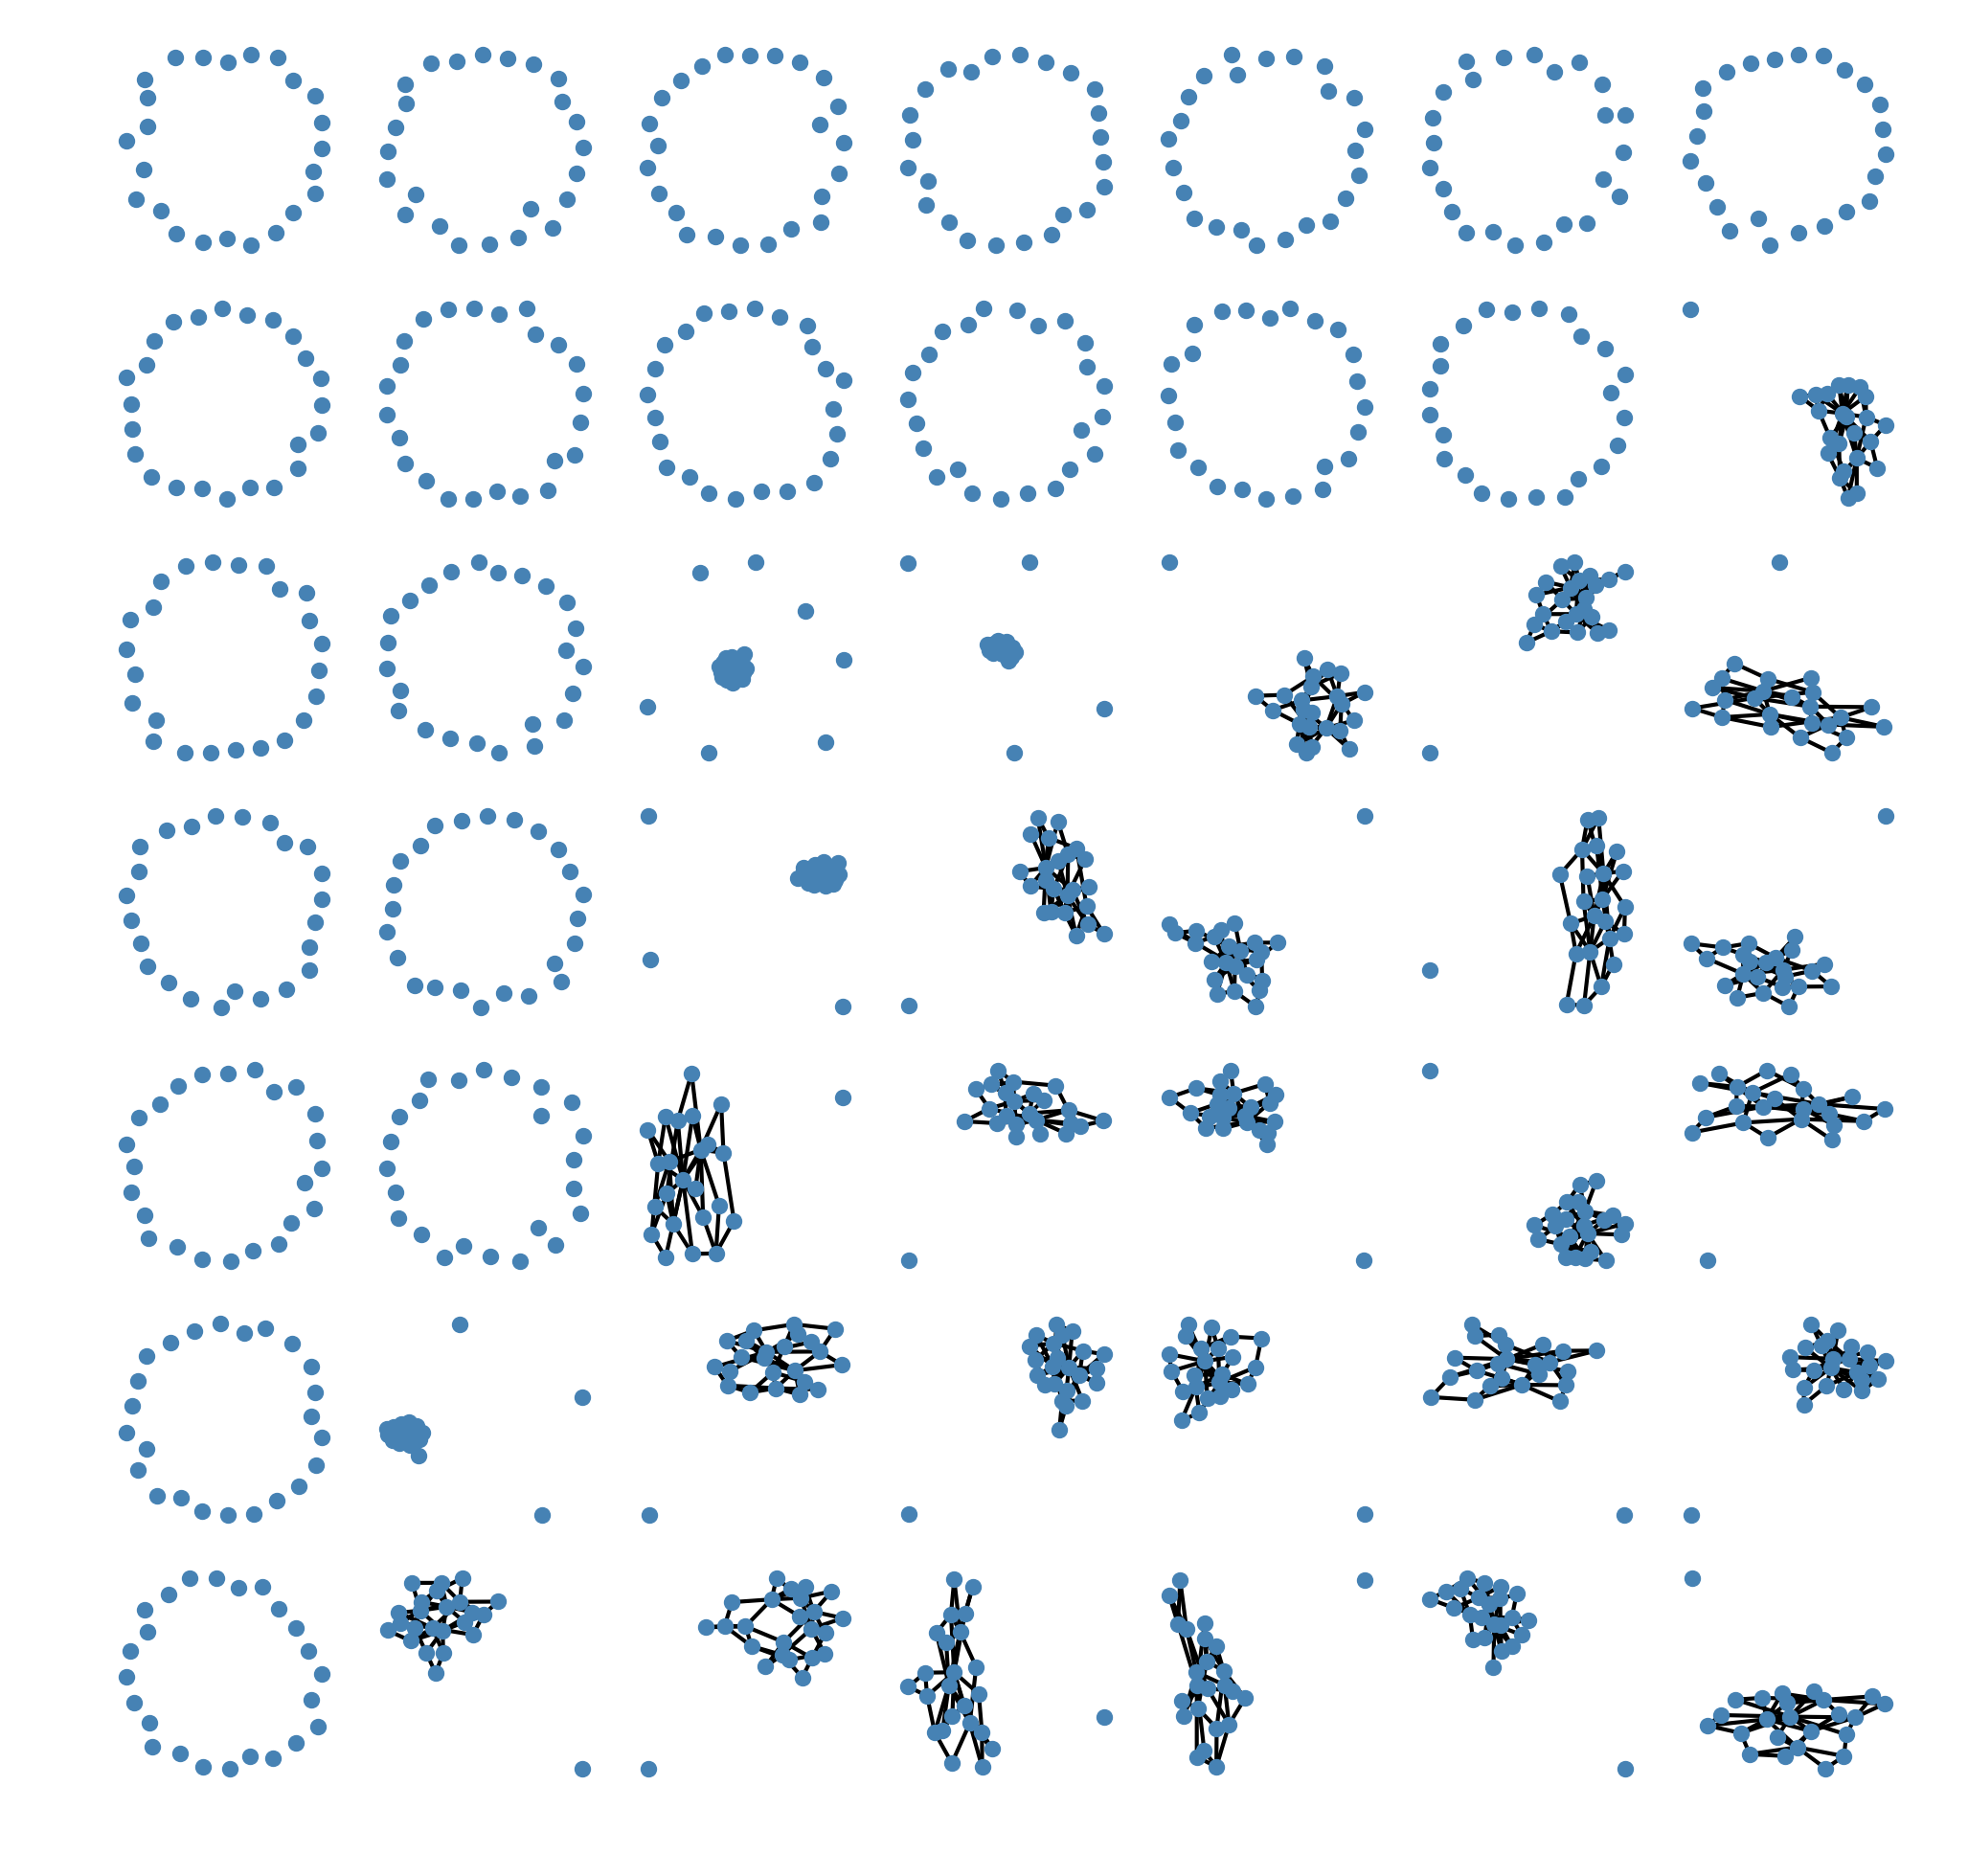

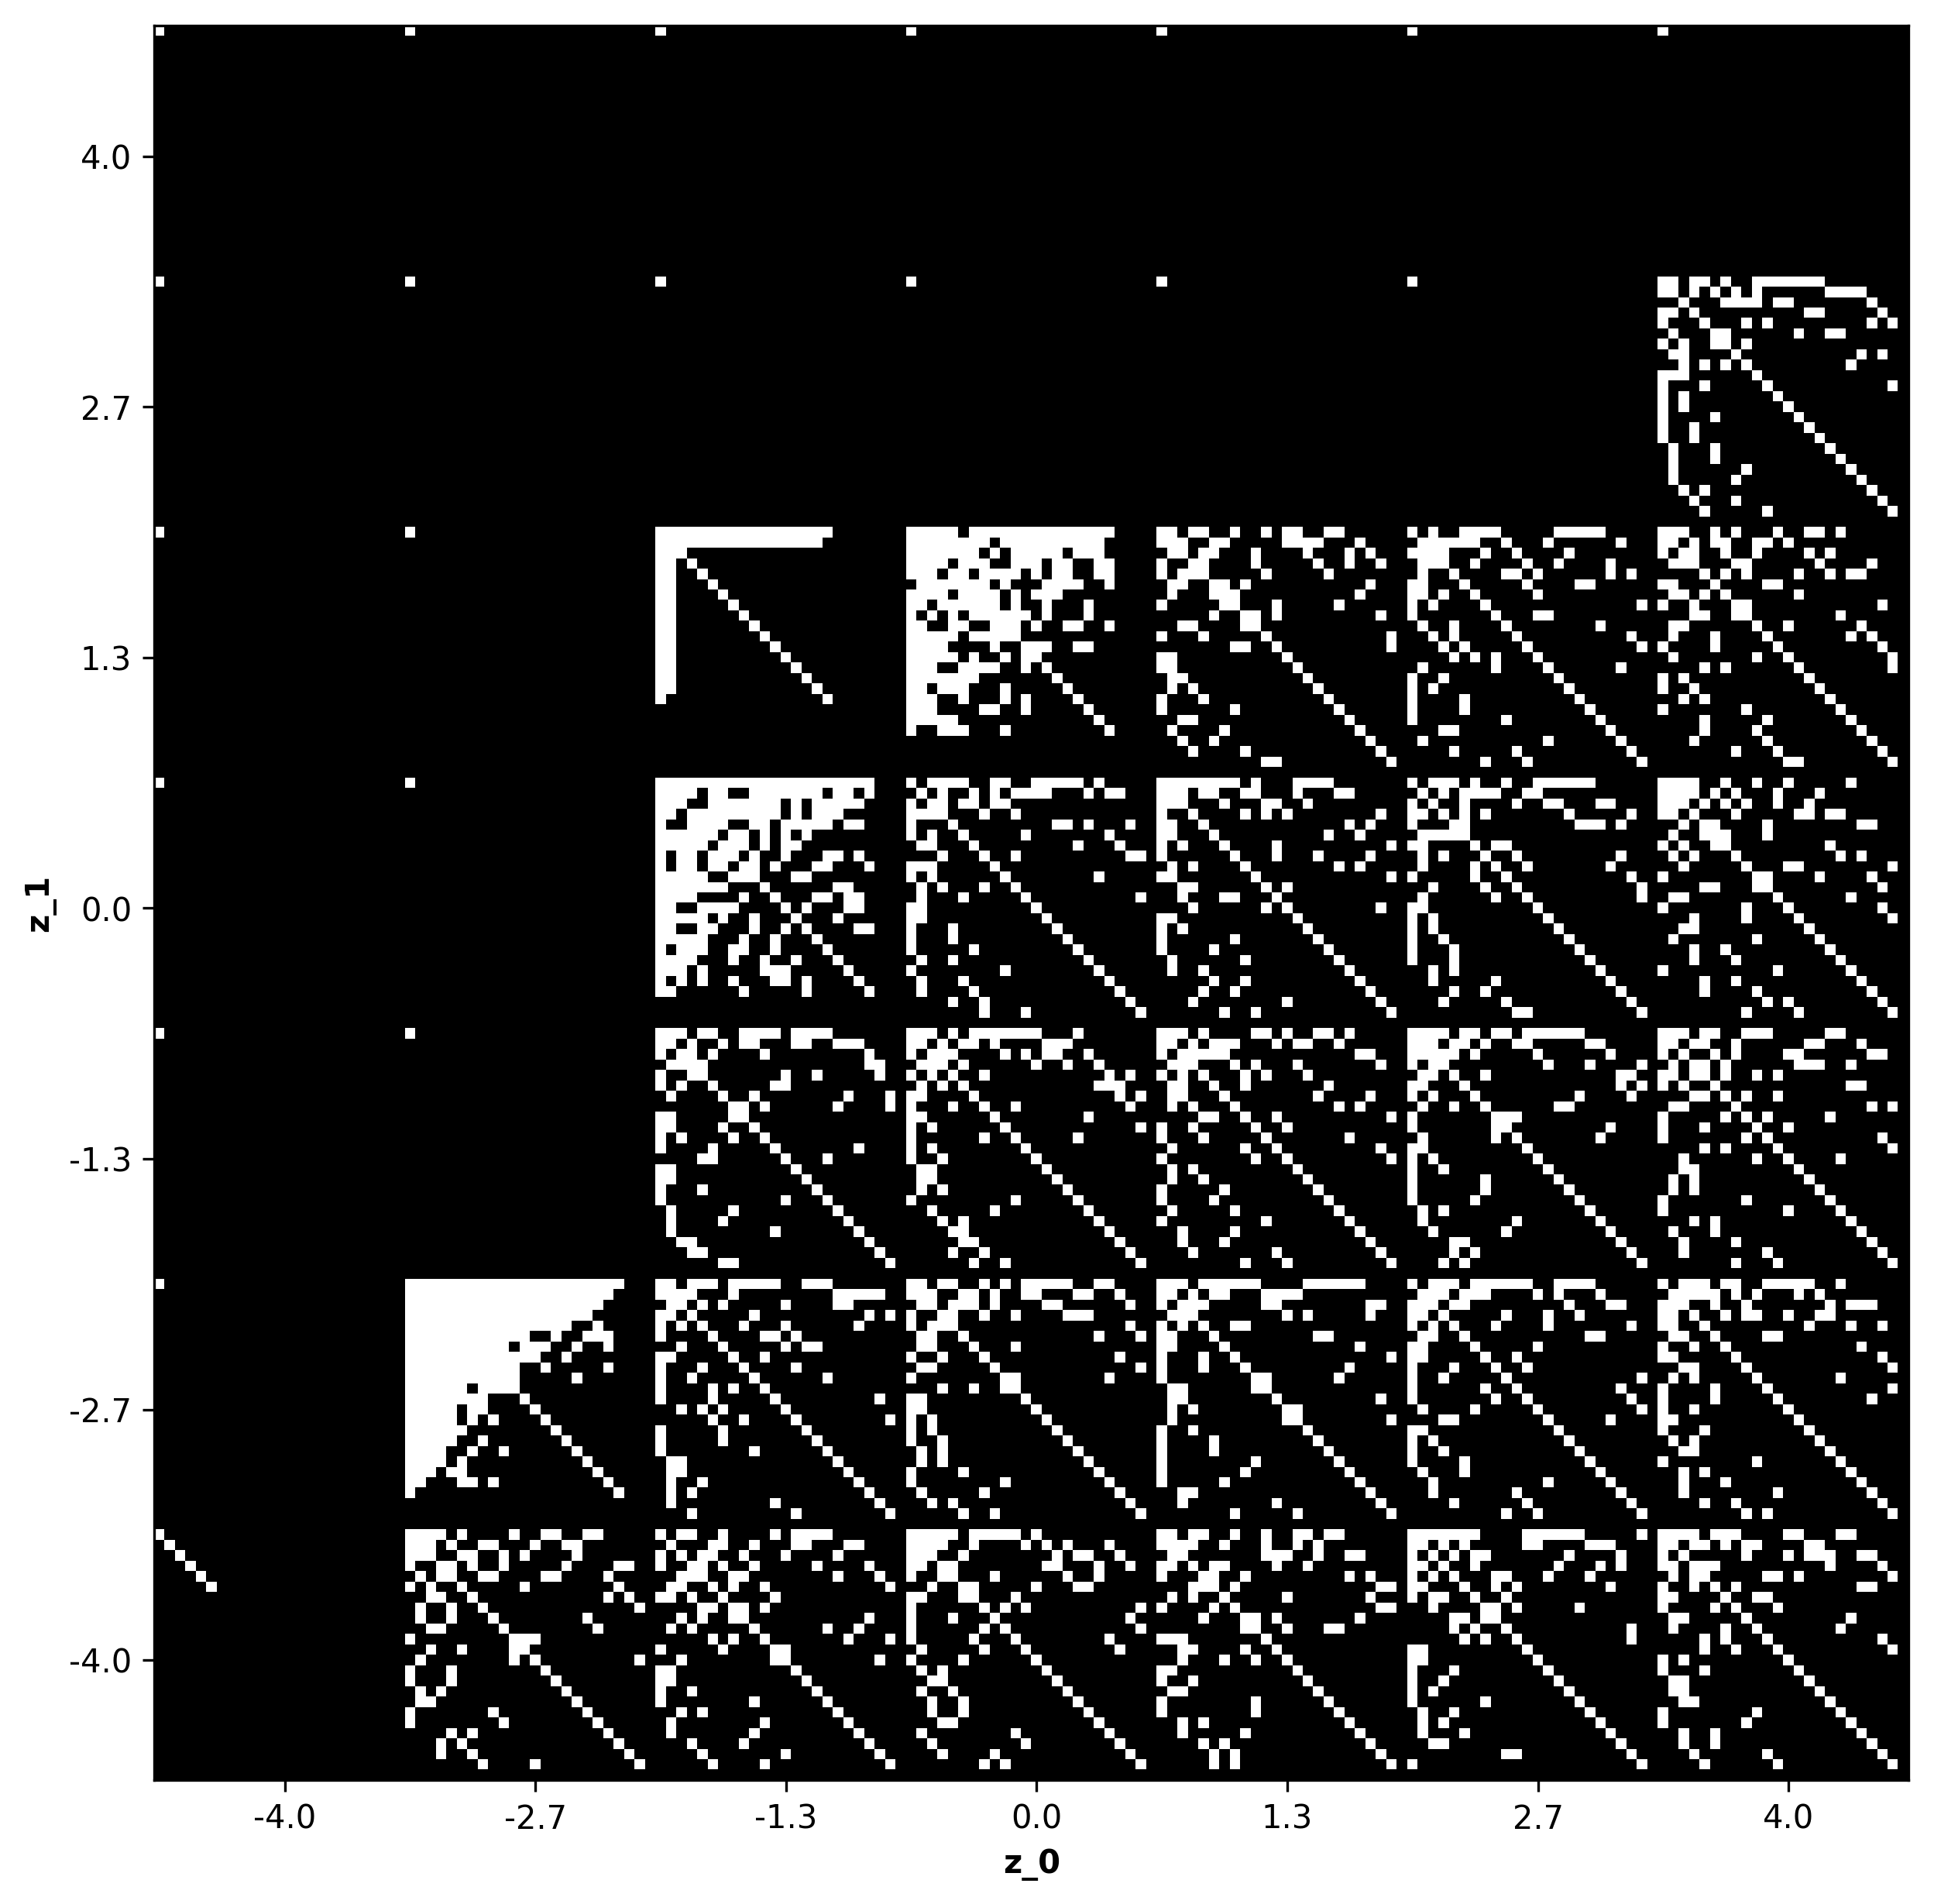

In [215]:
## range, normal, z
analyzeArgs = {"z": [0,1], "graph_type": "HK", "sample": "range", "act_range": [-4, 4], "act_scale": 5, "size_of_manifold": 7, "save_plots": False}
generate_param_graph_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)

## "cluster_coef", "assort", "avg_degree"

latent dimensions: 2


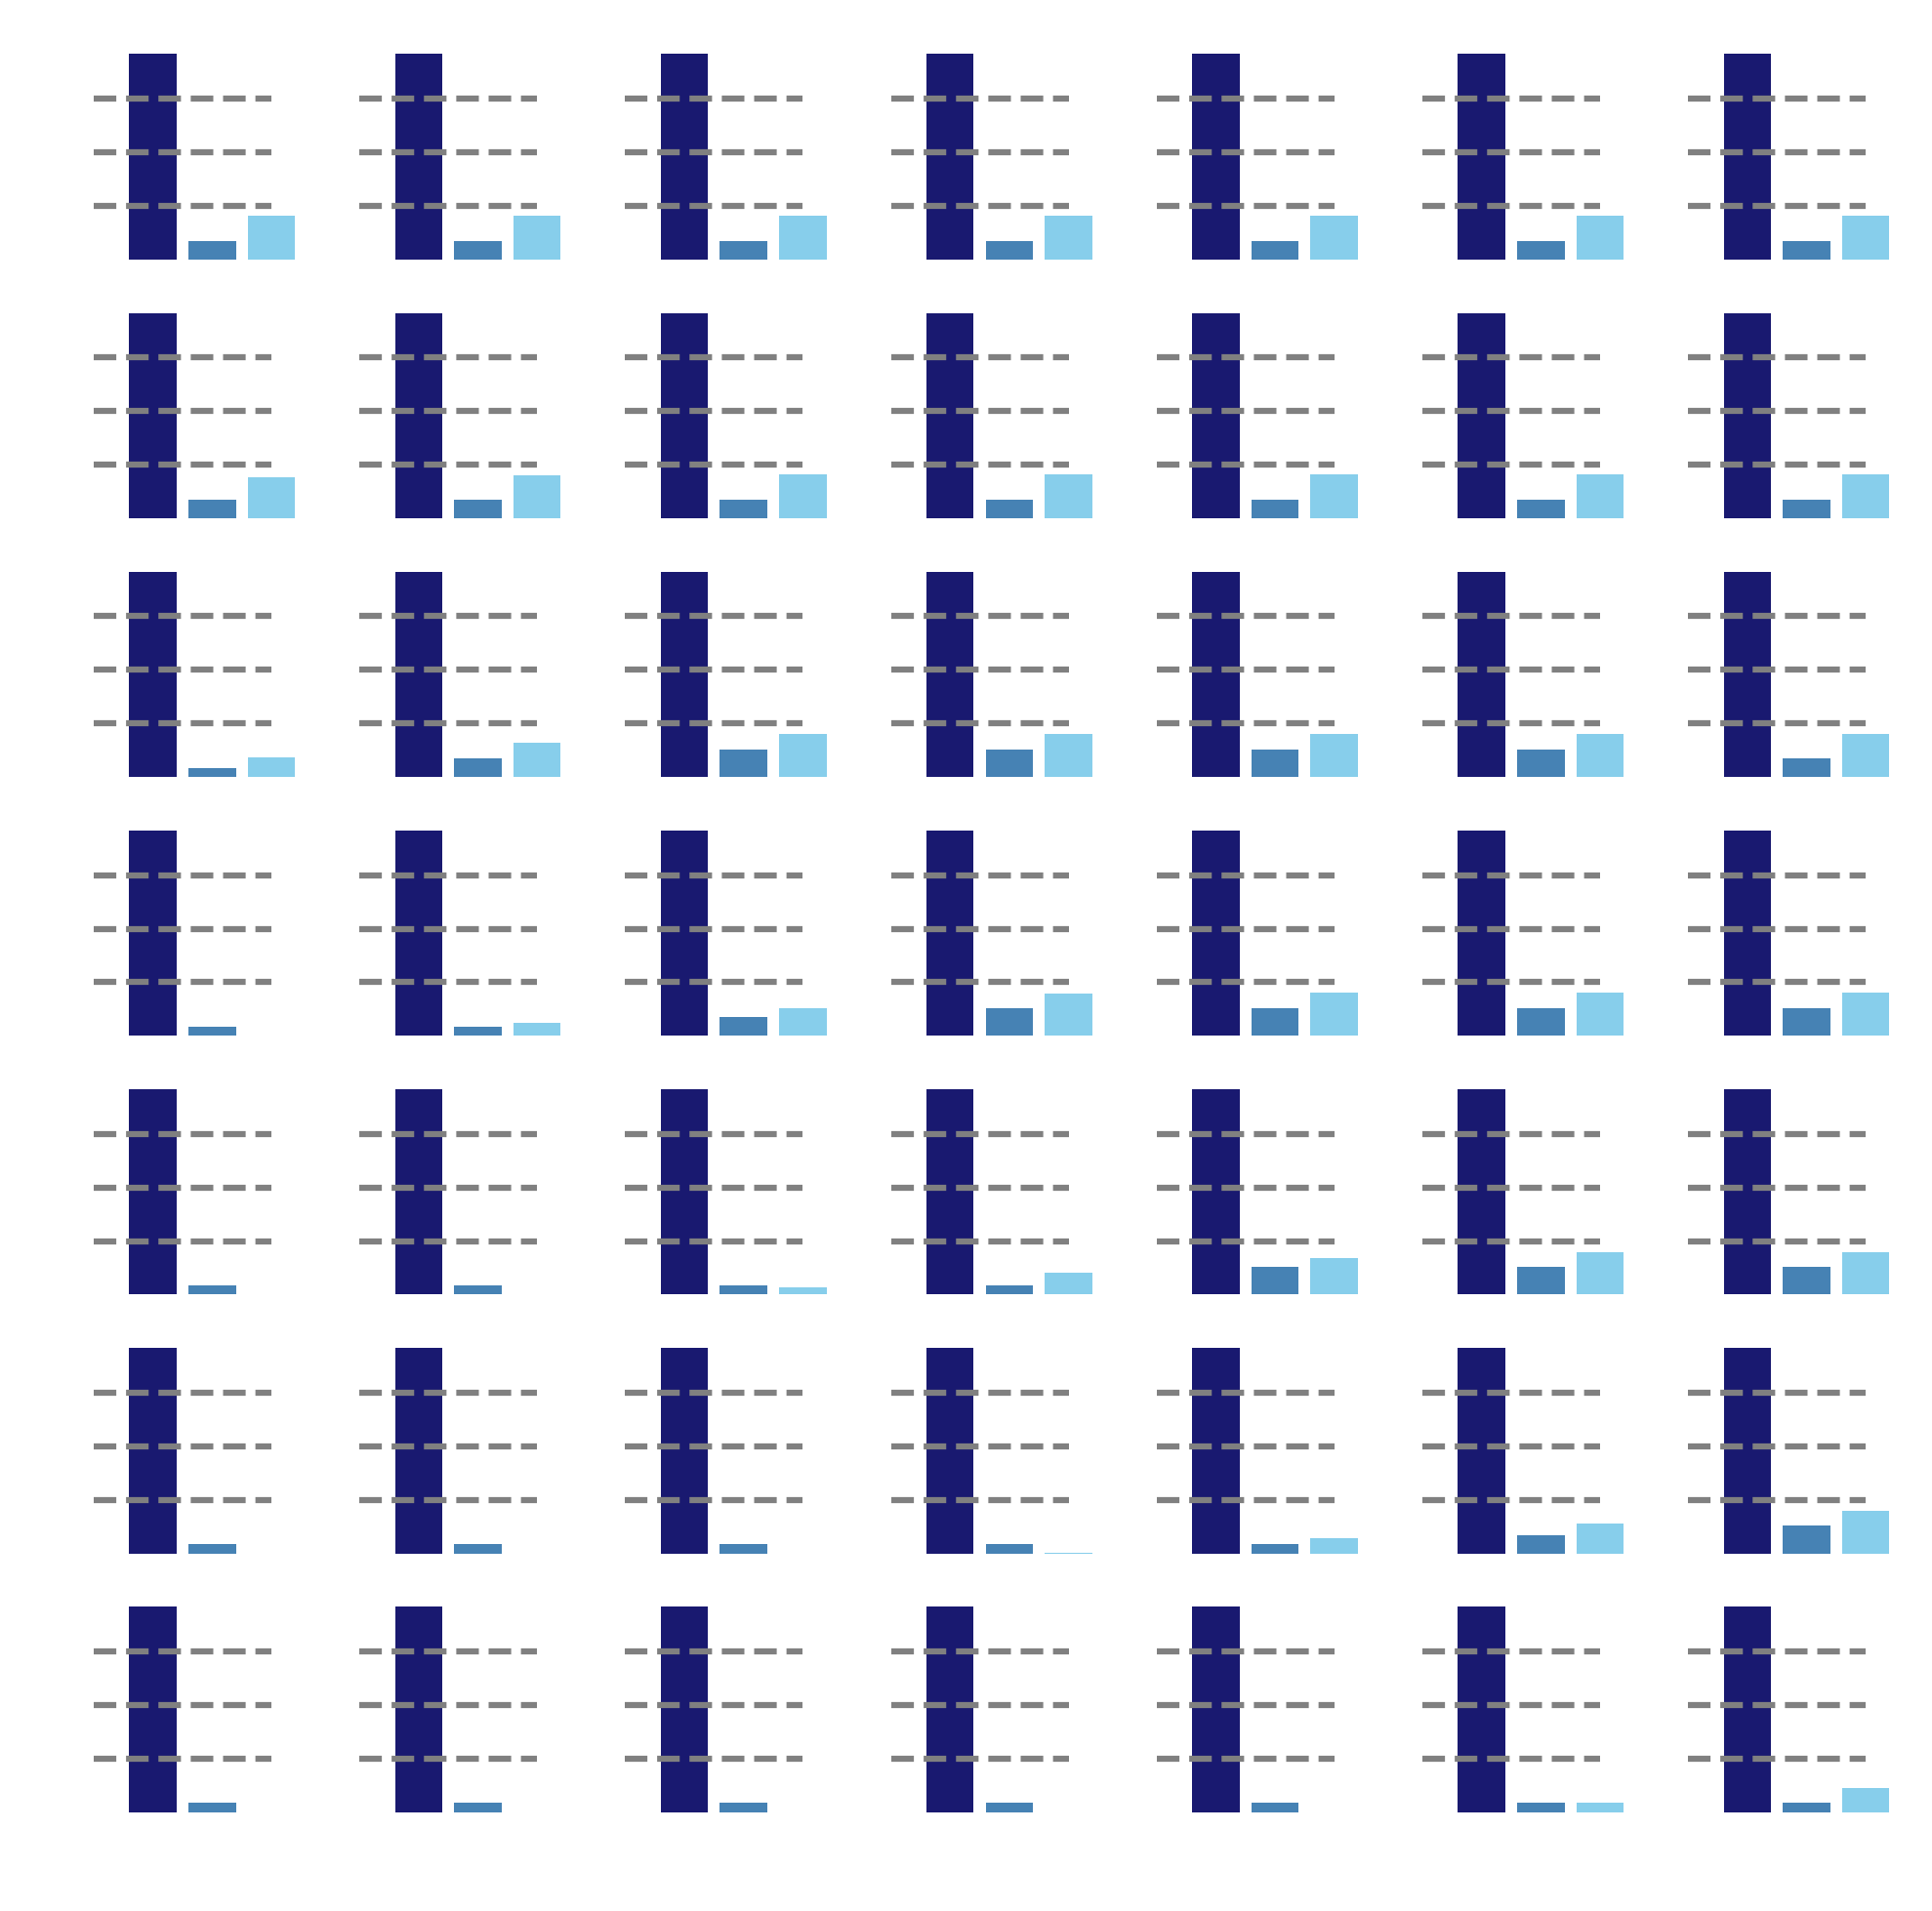

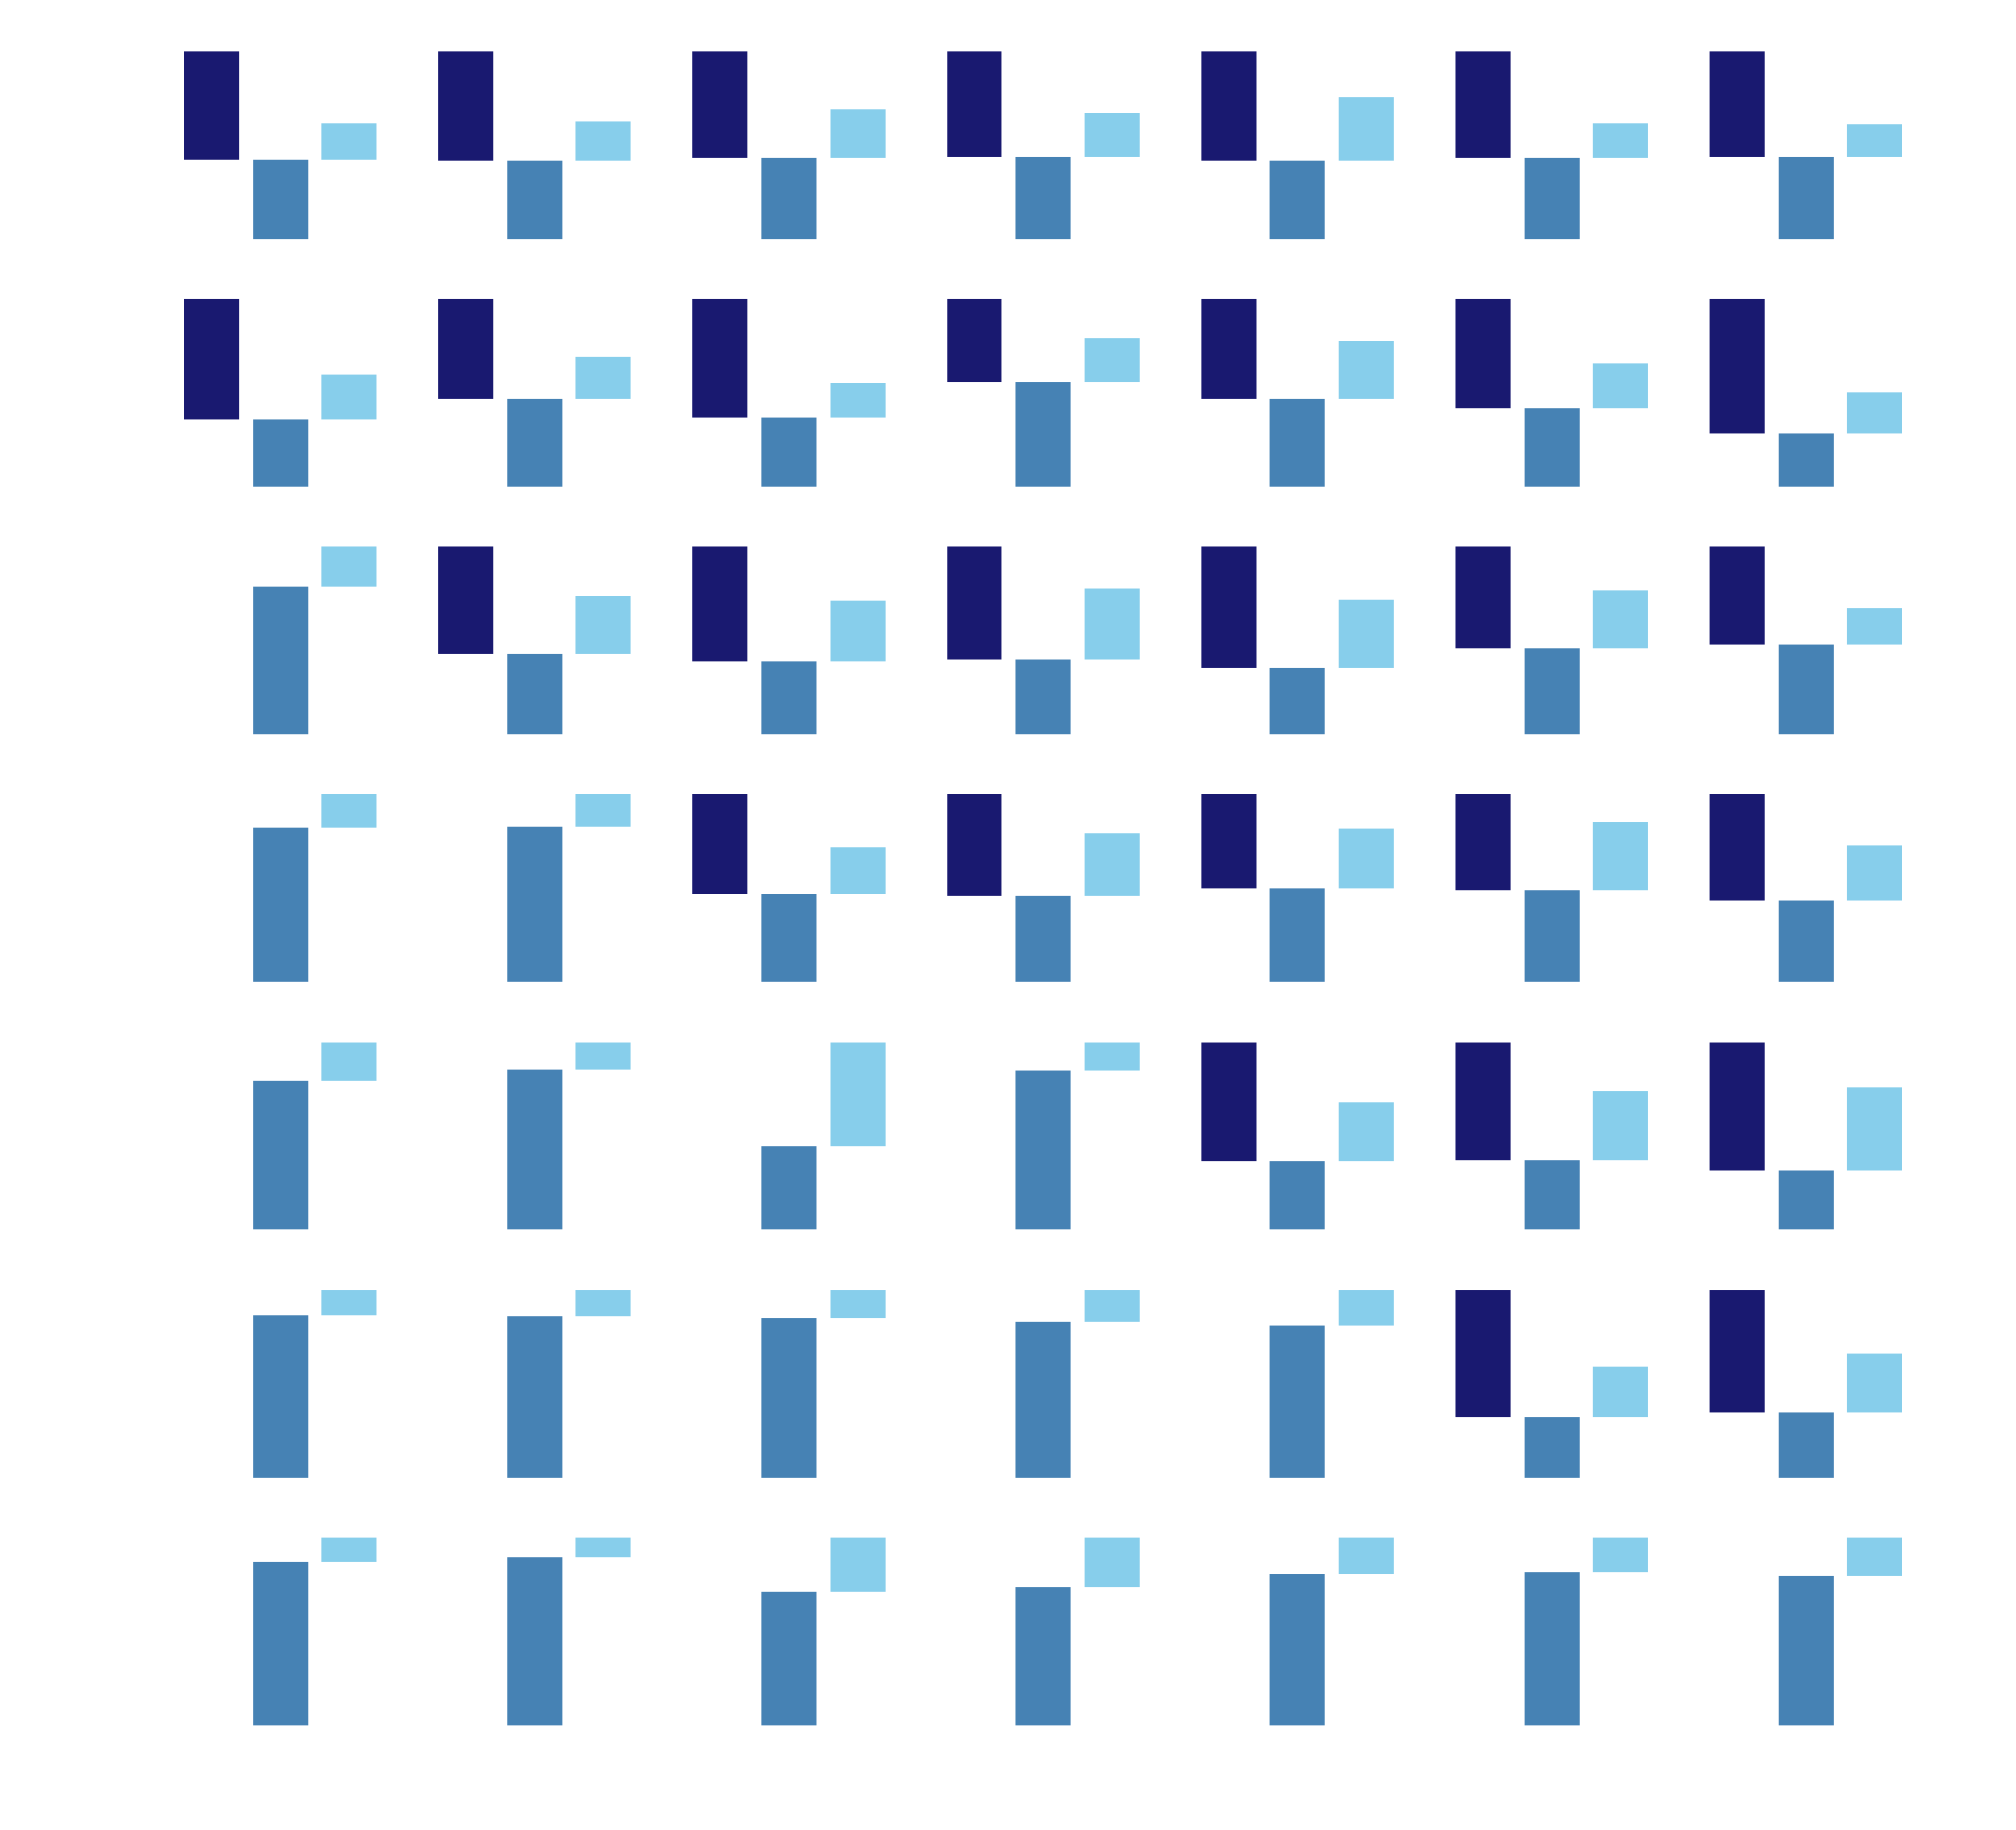

In [210]:
analyzeArgs["plot"] ="topol"
generate_param_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)